In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-zsijp0uj
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-zsijp0uj
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done
  Created wheel for gif_your_nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6631 sha256=00056da34d0b98864f1c9d760233bae2ac2a08ea3813d017f13a73818fd5f18e
  Stored in directory: /tmp/pip-ephem-wheel-cache-npwortsl/wheels/3a/c2/0b/c08f2425925519bb014e107d2919dadc2556ec5e7c205e4472
Successfully built gif_your_nifti


ModuleNotFoundError: No module named 'tensorflow.keras.layers.experimental'

In [18]:
pip install tensorflow.keras.layers.experimental

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.layers.experimental (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.layers.experimental
Note: you may need to restart the kernel to use updated packages.


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

Text(0.5, 1.0, 'Mask')

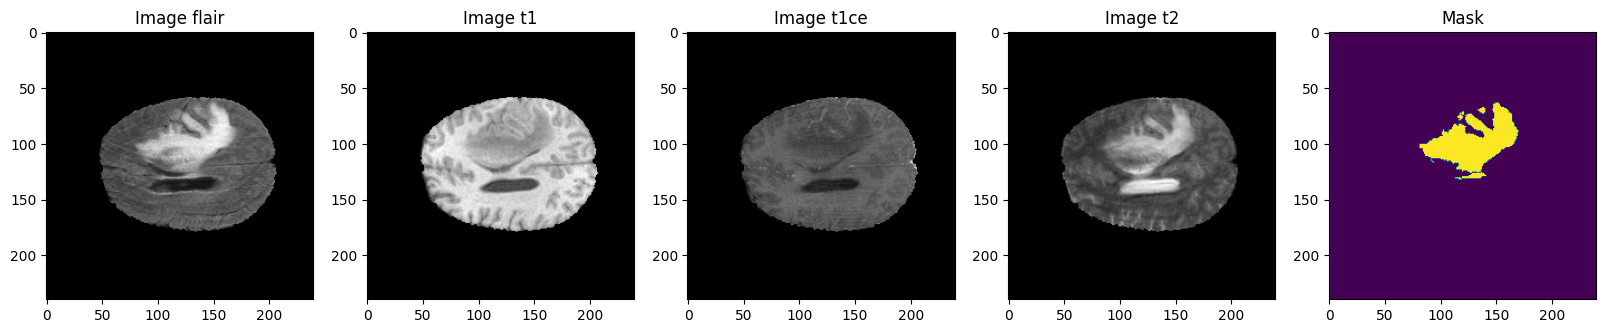

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshTRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')
ow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


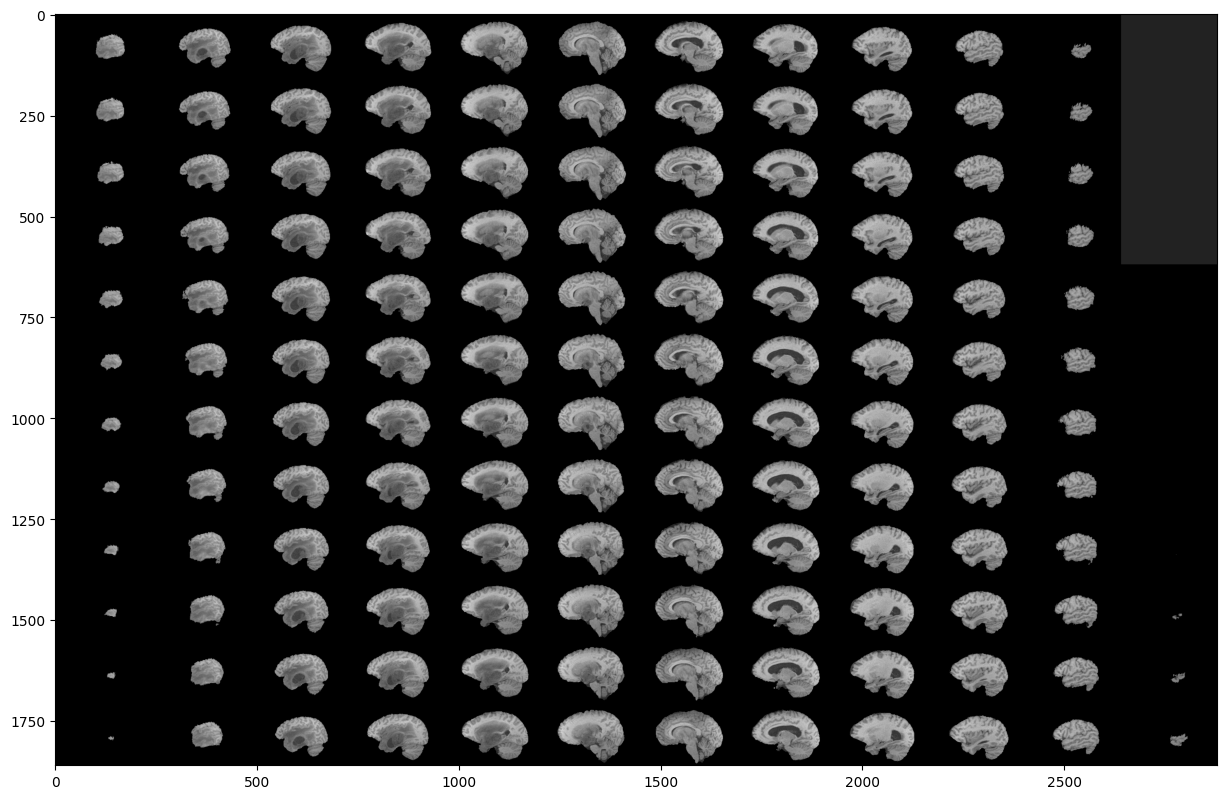

In [5]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

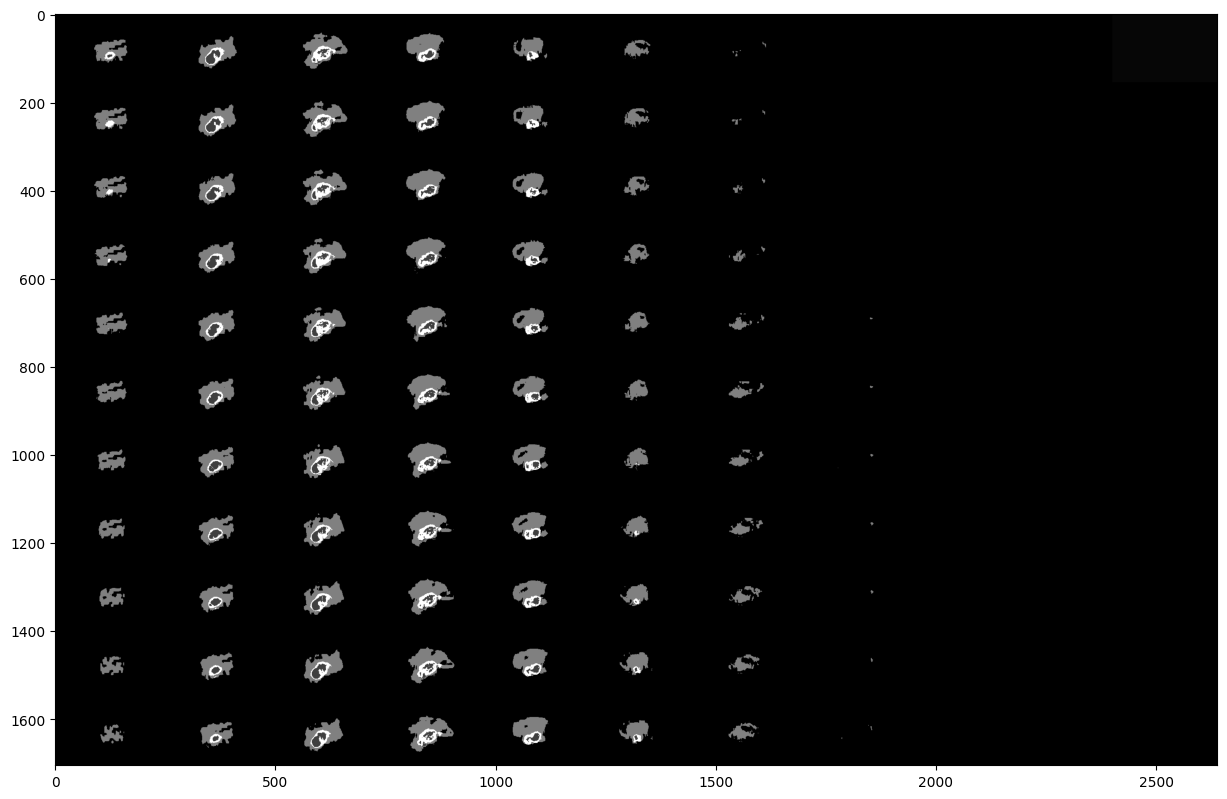

In [6]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [7]:
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

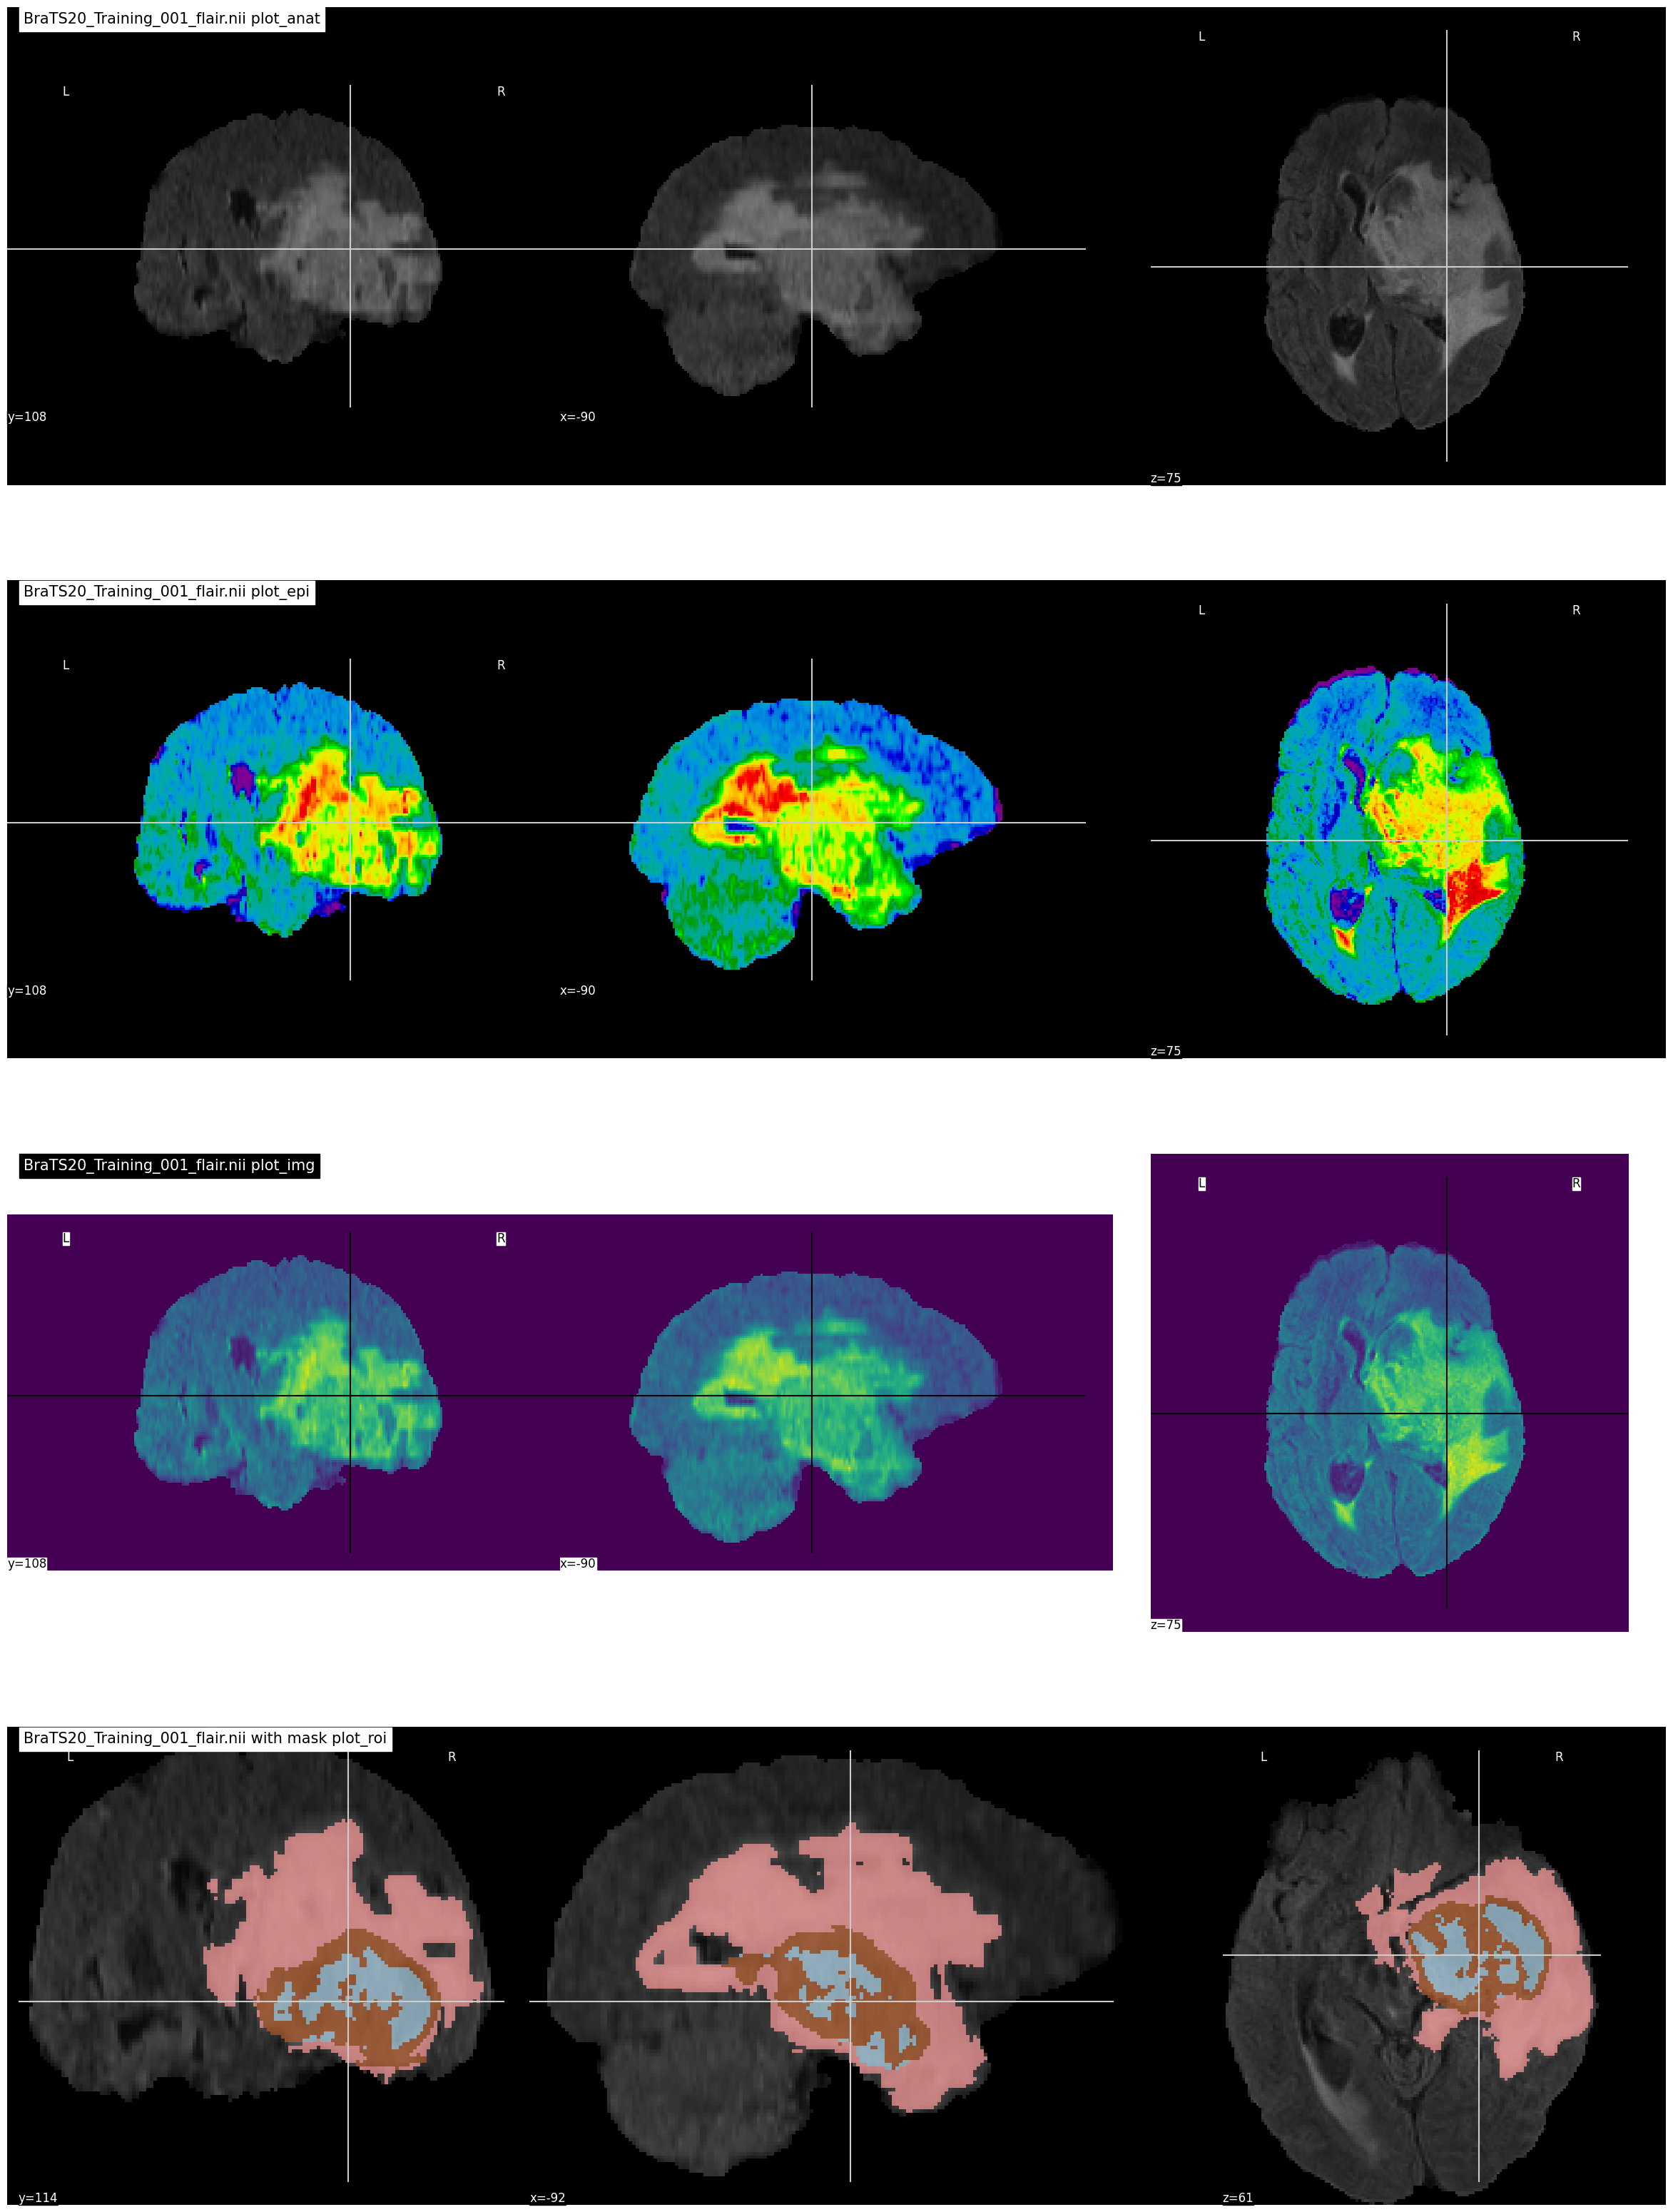

In [8]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [8]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [9]:
IMG_SIZE=128

In [10]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

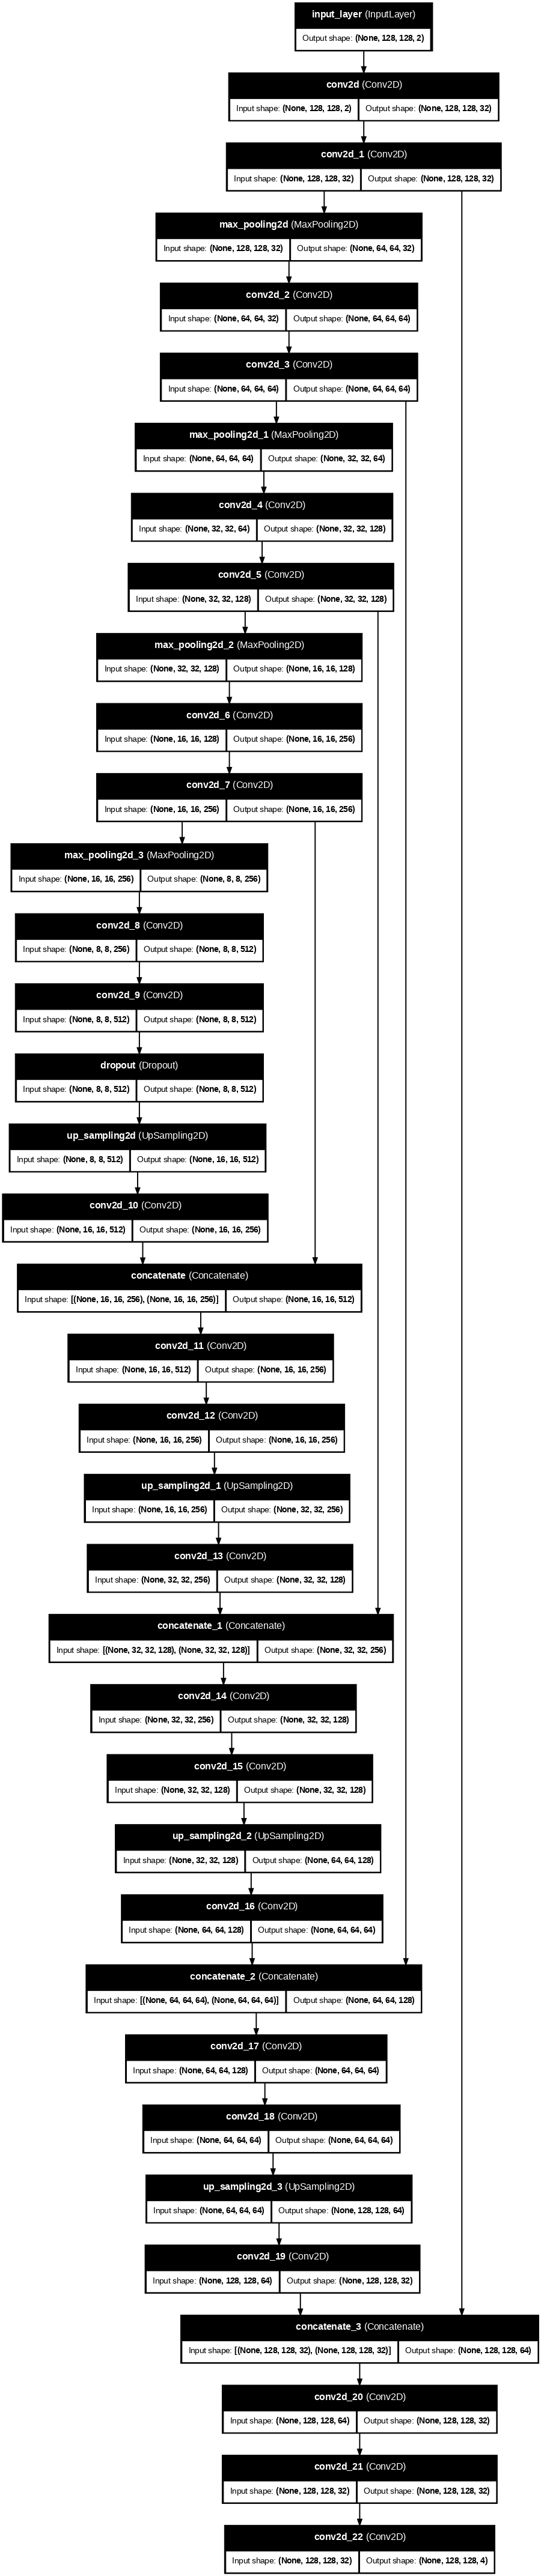

In [11]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [12]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

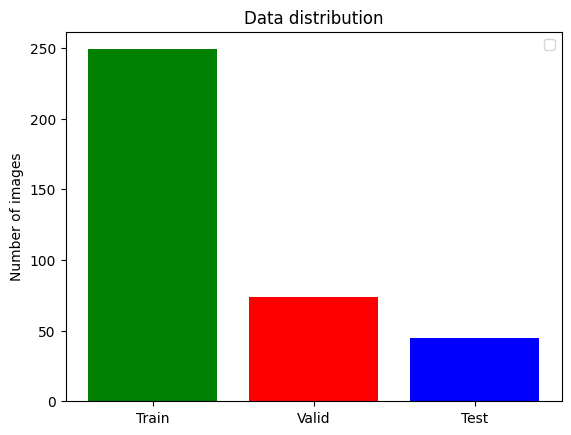

In [14]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [15]:
csv_logger = CSVLogger('training.log', separator=',', append=False)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=0,
        patience=2,
        verbose=1,
        mode='auto'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.000001,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',  # Corrected file extension
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    ),
    csv_logger
]

In [16]:
from tensorflow.keras import backend as K

K.clear_session()

# Debugging: Inspect generators
for i, (x_batch, y_batch) in enumerate(training_generator):
    print(f"Training Batch {i}: Input shape={x_batch.shape}, Output shape={y_batch.shape}")
    if i == 0:
        break

for i, (x_batch, y_batch) in enumerate(valid_generator):
    print(f"Validation Batch {i}: Input shape={x_batch.shape}, Output shape={y_batch.shape}")
    if i == 0:
        break

# Debugging: Add custom callback
class DebugCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            print("Logs are None!")
        else:
            print(f"Epoch {epoch + 1} logs:", logs)

callbacks.append(DebugCallback())

# Train the model
history = model.fit(
    training_generator,
    epochs=35,
    steps_per_epoch=len(train_ids),
    validation_data=valid_generator,
    callbacks=callbacks
)

# Save the model
model.save("model_x1_1.h5")

Training Batch 0: Input shape=(100, 128, 128, 2), Output shape=(100, 128, 128, 4)
Validation Batch 0: Input shape=(100, 128, 128, 2), Output shape=(100, 128, 128, 4)
Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9662 - dice_coef: 0.2594 - dice_coef_edema: 0.1096 - dice_coef_enhancing: 0.0423 - dice_coef_necrotic: 0.0536 - loss: 0.1834 - mean_io_u: 0.4846 - precision: 0.9580 - sensitivity: 0.9439 - specificity: 0.9943
Epoch 1: val_loss improved from inf to 0.07286, saving model to model_.01-0.072862.weights.h5
Epoch 1 logs: {'accuracy': 0.9794857501983643, 'dice_coef': 0.2713267207145691, 'dice_coef_edema': 0.13246846199035645, 'dice_coef_enhancing': 0.06437580287456512, 'dice_coef_necrotic': 0.0632503405213356, 'loss': 0.10472392290830612, 'mean_io_u': 0.4988881051540375, 'precision': 0.9793585538864136, 'sensitivity': 0.9740848541259766, 'specificity': 0.994502604007721, 'val_accuracy': 0.9844009876251221, 'val_dice_coef': 0.28124096989631653, 'val_dice_coef_edema': 0.1316237896680832, 'val_dice_coef_enhancing': 0.06806662678718567, 'val_dice_coef_necrotic': 0.07631967216730118, 'val_loss': 0.07286197692155838, 'val_mean_io_u': 0.499429

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.07286
Epoch 2 logs: {'accuracy': 0.0, 'dice_coef': 0.0, 'dice_coef_edema': 0.0, 'dice_coef_enhancing': 0.0, 'dice_coef_necrotic': 0.0, 'loss': 0.0, 'mean_io_u': 0.0, 'precision': 0.0, 'sensitivity': 0.0, 'specificity': 0.0, 'val_accuracy': 0.984400749206543, 'val_dice_coef': 0.28124094009399414, 'val_dice_coef_edema': 0.13162380456924438, 'val_dice_coef_enhancing': 0.06806664168834686, 'val_dice_coef_necrotic': 0.07631967216730118, 'val_loss': 0.07286199927330017, 'val_mean_io_u': 0.4994295835494995, 'val_precision': 0.984987735748291, 'val_sensitivity': 0.9839404225349426, 'val_specificity': 0.9950041770935059, 'learning_rate': 0.0010000000474974513}
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - dice_coef_edema: 0.0000e+00 - dice_coef_enhancing: 0.0000e+00 - dice_coef_necrotic: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0

In [2]:
import torch
import torch.nn as nn

class CustomResNet3D(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomResNet3D, self).__init__()
        
        # Initial convolution layer
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=(1, 2, 2), padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(self._make_residual_block(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(self._make_residual_block(out_channels, out_channels, 1))
        return nn.Sequential(*layers)
    
    def _make_residual_block(self, in_channels, out_channels, stride):
        return ResidualBlock3D(in_channels, out_channels, stride)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return torch.sigmoid(x)  # Sigmoid for binary classification

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

In [5]:
from torchviz import make_dot

# Create a dummy input tensor (batch_size=1, channels=1, depth=128, height=128, width=128)
dummy_input = torch.randn(1, 1, 128, 128, 128)

# Instantiate the model
model = CustomResNet3D(num_classes=1)

# Forward pass to generate the computational graph
output = model(dummy_input)

# Visualize the model
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("custom_resnet3d", format="png")  # Save as PNG

'custom_resnet3d.png'

In [4]:
pip install torchviz

Note: you may need to restart the kernel to use updated packages.


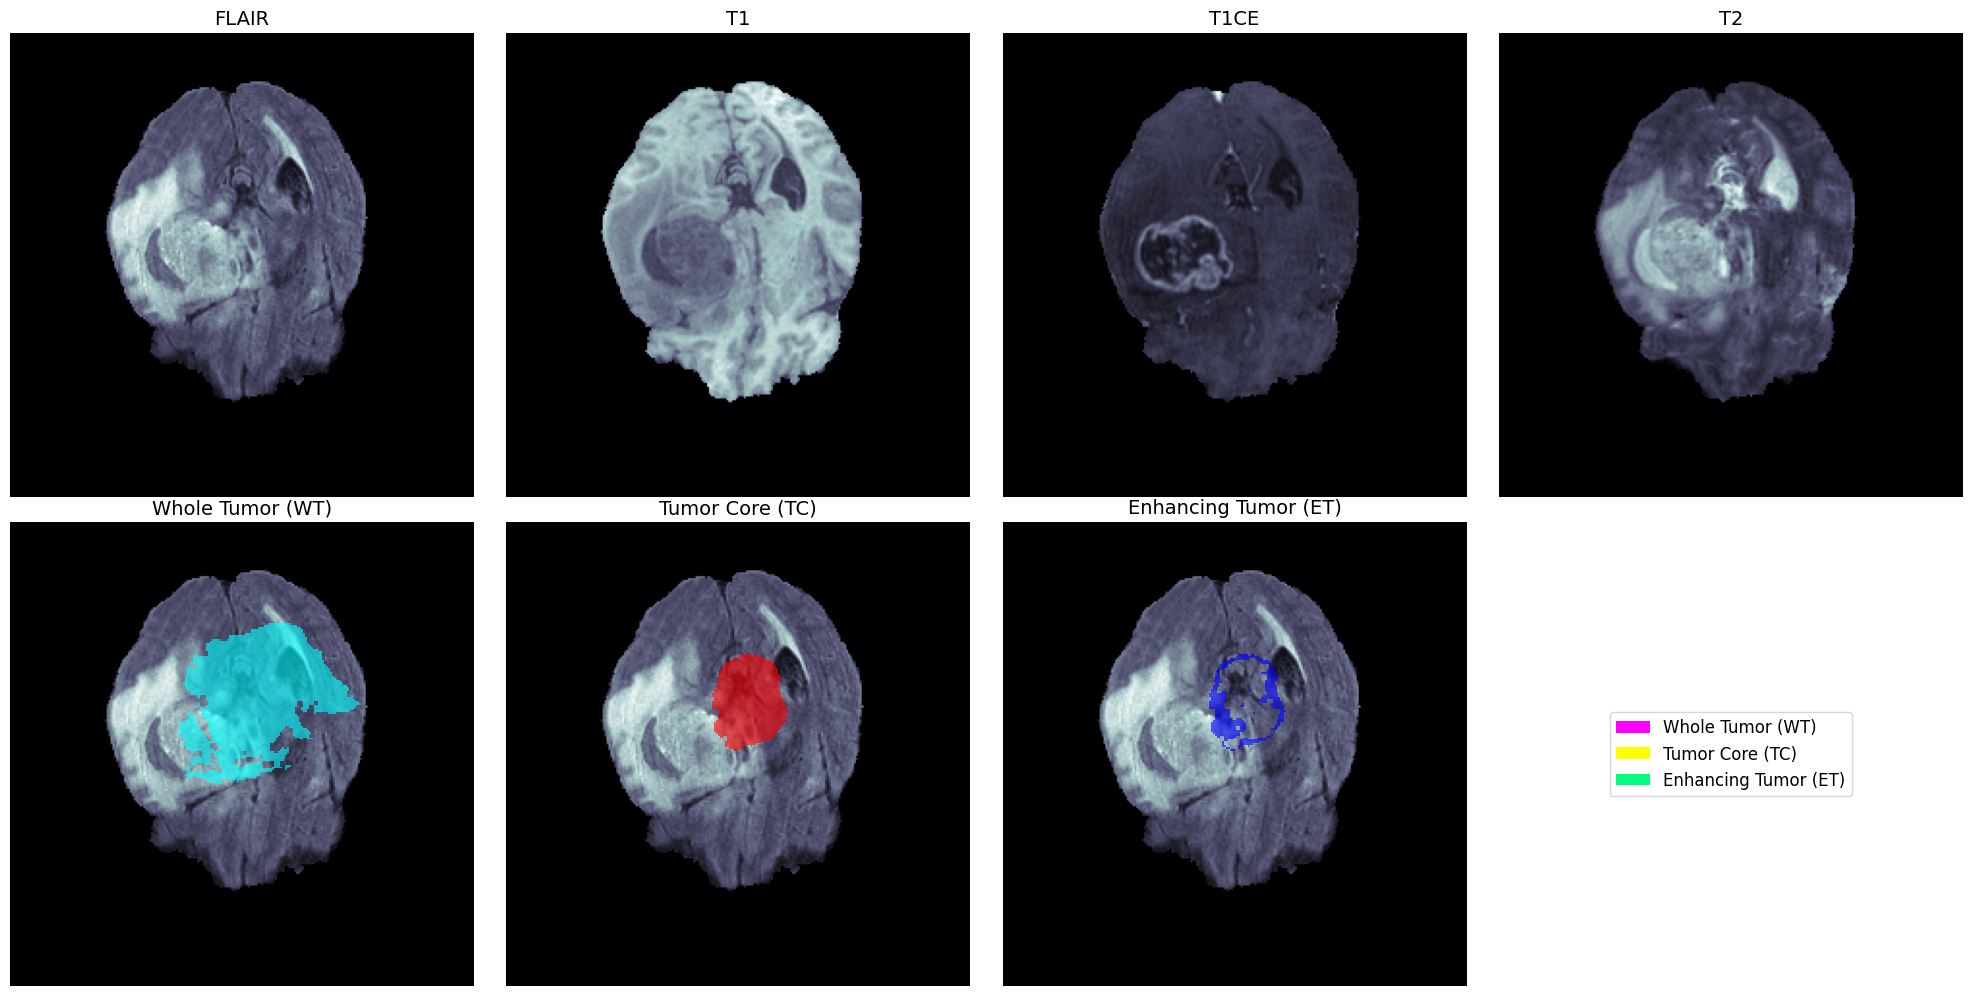

In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch

# Path to the dataset
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Select a sample case
sample_id = "BraTS20_Training_001"
sample_dir = os.path.join(data_dir, sample_id)

# File paths
flair_path = os.path.join(sample_dir, f"{sample_id}_flair.nii")
t1_path = os.path.join(sample_dir, f"{sample_id}_t1.nii")
t1ce_path = os.path.join(sample_dir, f"{sample_id}_t1ce.nii")
t2_path = os.path.join(sample_dir, f"{sample_id}_t2.nii")
mask_path = os.path.join(sample_dir, f"{sample_id}_seg.nii")

# Load data
def load_nifti(file_path):
    img = nib.load(file_path)
    return np.array(img.get_fdata(), dtype=np.float32)

flair = load_nifti(flair_path)
t1 = load_nifti(t1_path)
t1ce = load_nifti(t1ce_path)
t2 = load_nifti(t2_path)
mask = load_nifti(mask_path).astype(np.uint8)

# Preprocess mask labels
def preprocess_mask_labels(mask):
    mask_WT = mask.copy()
    mask_WT[mask_WT == 1] = 1  # NCR/NET
    mask_WT[mask_WT == 2] = 1  # ED
    mask_WT[mask_WT == 4] = 1  # ET

    mask_TC = mask.copy()
    mask_TC[mask_TC == 1] = 1  # NCR/NET
    mask_TC[mask_TC == 2] = 0  # Exclude ED
    mask_TC[mask_TC == 4] = 1  # ET

    mask_ET = mask.copy()
    mask_ET[mask_ET == 1] = 0  # Exclude NCR/NET
    mask_ET[mask_ET == 2] = 0  # Exclude ED
    mask_ET[mask_ET == 4] = 1  # ET

    return mask_WT, mask_TC, mask_ET

mask_WT, mask_TC, mask_ET = preprocess_mask_labels(mask)

# Select a slice for visualization
slice_idx = 65

# Plotting function
def plot_data_with_masks(flair, t1, t1ce, t2, mask_WT, mask_TC, mask_ET, slice_idx):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    # Plot modalities
    axes[0].imshow(np.rot90(flair[:, :, slice_idx]), cmap="bone")
    axes[0].set_title("FLAIR", fontsize=14)
    axes[0].axis("off")

    axes[1].imshow(np.rot90(t1[:, :, slice_idx]), cmap="bone")
    axes[1].set_title("T1", fontsize=14)
    axes[1].axis("off")

    axes[2].imshow(np.rot90(t1ce[:, :, slice_idx]), cmap="bone")
    axes[2].set_title("T1CE", fontsize=14)
    axes[2].axis("off")

    axes[3].imshow(np.rot90(t2[:, :, slice_idx]), cmap="bone")
    axes[3].set_title("T2", fontsize=14)
    axes[3].axis("off")

    # Plot masks
    axes[4].imshow(np.rot90(flair[:, :, slice_idx]), cmap="bone")
    axes[4].imshow(np.ma.masked_where(mask_WT[:, :, slice_idx] == 0, mask_WT[:, :, slice_idx]), cmap="cool", alpha=0.6)
    axes[4].set_title("Whole Tumor (WT)", fontsize=14)
    axes[4].axis("off")

    axes[5].imshow(np.rot90(flair[:, :, slice_idx]), cmap="bone")
    axes[5].imshow(np.ma.masked_where(mask_TC[:, :, slice_idx] == 0, mask_TC[:, :, slice_idx]), cmap="autumn", alpha=0.6)
    axes[5].set_title("Tumor Core (TC)", fontsize=14)
    axes[5].axis("off")

    axes[6].imshow(np.rot90(flair[:, :, slice_idx]), cmap="bone")
    axes[6].imshow(np.ma.masked_where(mask_ET[:, :, slice_idx] == 0, mask_ET[:, :, slice_idx]), cmap="winter", alpha=0.6)
    axes[6].set_title("Enhancing Tumor (ET)", fontsize=14)
    axes[6].axis("off")

    # Legend
    legend_elements = [
        Patch(facecolor=cm.cool(1.0), label="Whole Tumor (WT)"),
        Patch(facecolor=cm.autumn(1.0), label="Tumor Core (TC)"),
        Patch(facecolor=cm.winter(1.0), label="Enhancing Tumor (ET)"),
    ]
    axes[7].legend(handles=legend_elements, loc="center", fontsize=12)
    axes[7].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the data
plot_data_with_masks(flair, t1, t1ce, t2, mask_WT, mask_TC, mask_ET, slice_idx)

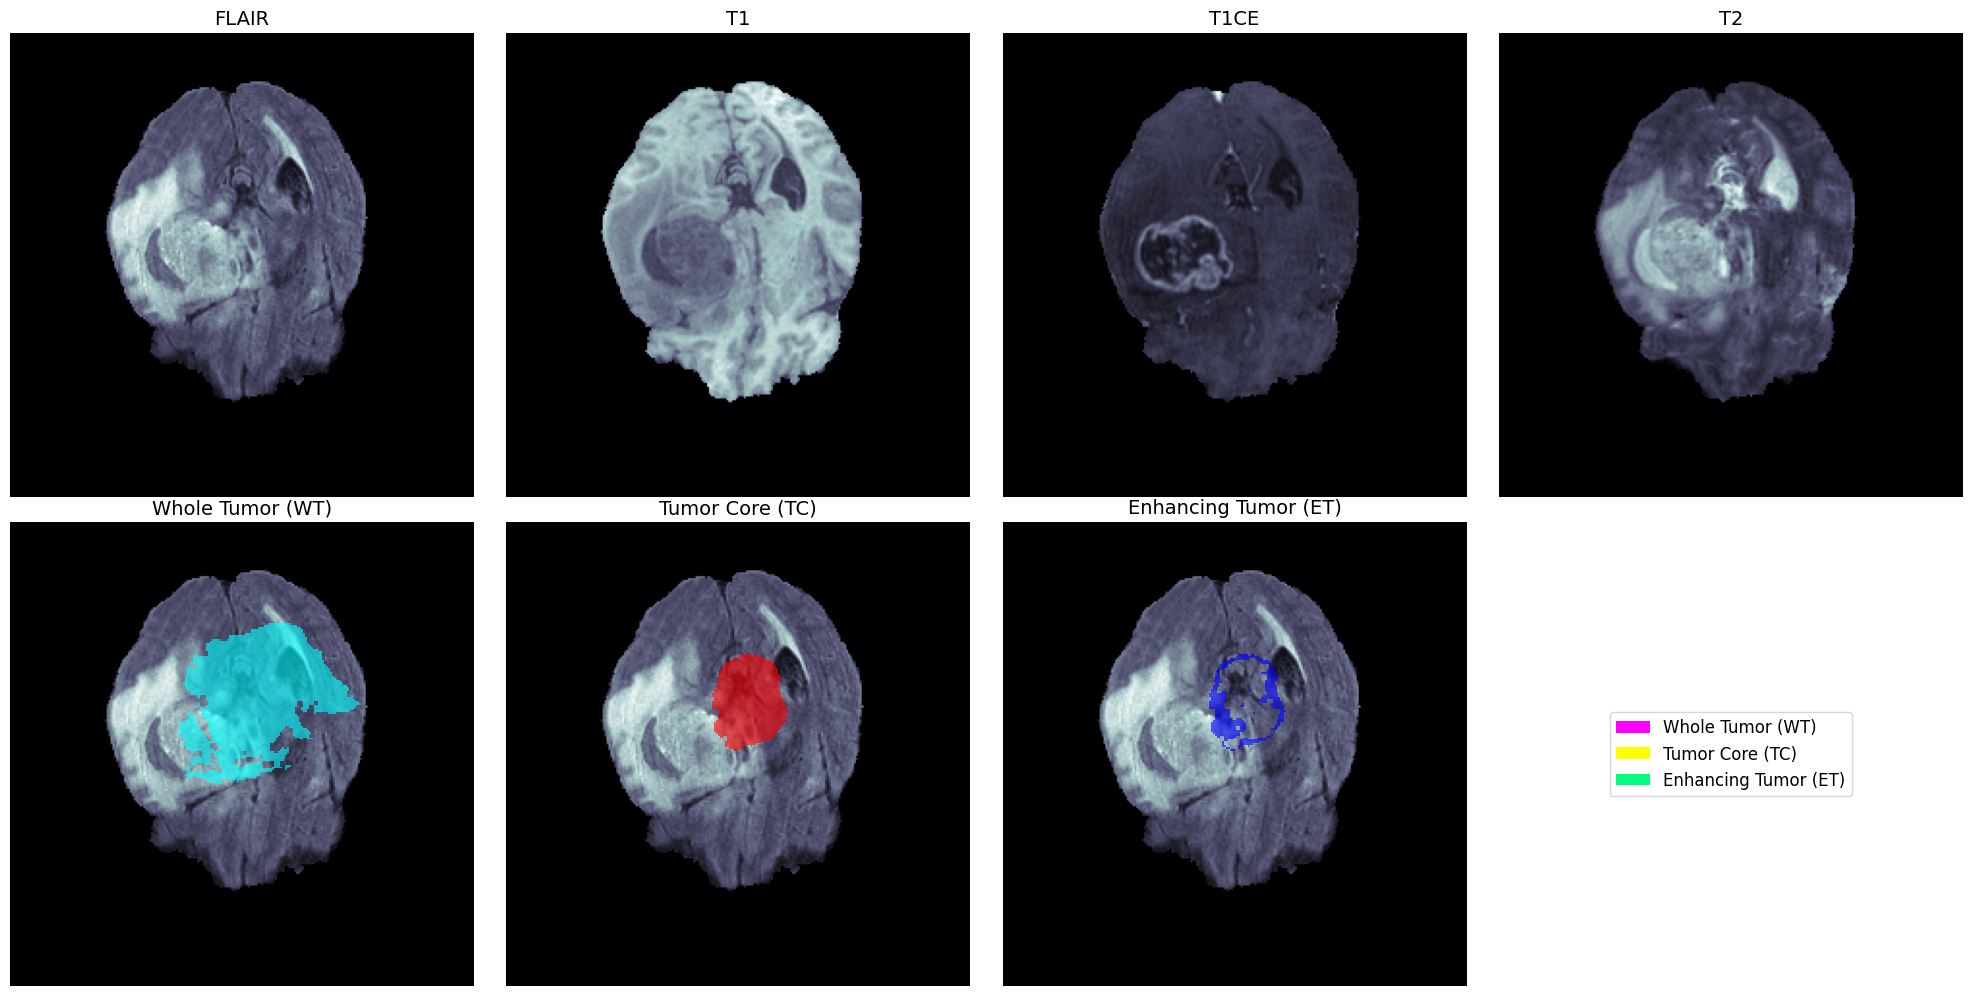

In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch

# Path to the dataset
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Select a sample case
sample_id = "BraTS20_Training_001"
sample_dir = os.path.join(data_dir, sample_id)

# File paths
flair_path = os.path.join(sample_dir, f"{sample_id}_flair.nii")
t1_path = os.path.join(sample_dir, f"{sample_id}_t1.nii")
t1ce_path = os.path.join(sample_dir, f"{sample_id}_t1ce.nii")
t2_path = os.path.join(sample_dir, f"{sample_id}_t2.nii")
mask_path = os.path.join(sample_dir, f"{sample_id}_seg.nii")

# Load data
def load_nifti(file_path):
    img = nib.load(file_path)
    return np.array(img.get_fdata(), dtype=np.float32)

flair = load_nifti(flair_path)
t1 = load_nifti(t1_path)
t1ce = load_nifti(t1ce_path)
t2 = load_nifti(t2_path)
mask = load_nifti(mask_path).astype(np.uint8)

# Preprocess mask labels
def preprocess_mask_labels(mask):
    mask_WT = mask.copy()
    mask_WT[mask_WT == 1] = 1  # NCR/NET
    mask_WT[mask_WT == 2] = 1  # ED
    mask_WT[mask_WT == 4] = 1  # ET

    mask_TC = mask.copy()
    mask_TC[mask_TC == 1] = 1  # NCR/NET
    mask_TC[mask_TC == 2] = 0  # Exclude ED
    mask_TC[mask_TC == 4] = 1  # ET

    mask_ET = mask.copy()
    mask_ET[mask_ET == 1] = 0  # Exclude NCR/NET
    mask_ET[mask_ET == 2] = 0  # Exclude ED
    mask_ET[mask_ET == 4] = 1  # ET

    return mask_WT, mask_TC, mask_ET

mask_WT, mask_TC, mask_ET = preprocess_mask_labels(mask)

# Select a slice for visualization
slice_idx = 65

# Plotting function
def plot_data_with_masks(flair, t1, t1ce, t2, mask_WT, mask_TC, mask_ET, slice_idx):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    # Plot modalities
    axes[0].imshow(np.rot90(flair[:, :, slice_idx]), cmap="bone")
    axes[0].set_title("FLAIR", fontsize=14)
    axes[0].axis("off")

    axes[1].imshow(np.rot90(t1[:, :, slice_idx]), cmap="bone")
    axes[1].set_title("T1", fontsize=14)
    axes[1].axis("off")

    axes[2].imshow(np.rot90(t1ce[:, :, slice_idx]), cmap="bone")
    axes[2].set_title("T1CE", fontsize=14)
    axes[2].axis("off")

    axes[3].imshow(np.rot90(t2[:, :, slice_idx]), cmap="bone")
    axes[3].set_title("T2", fontsize=14)
    axes[3].axis("off")

    # Plot masks
    axes[4].imshow(np.rot90(flair[:, :, slice_idx]), cmap="bone")
    axes[4].imshow(np.ma.masked_where(mask_WT[:, :, slice_idx] == 0, mask_WT[:, :, slice_idx]), cmap="cool", alpha=0.6)
    axes[4].set_title("Whole Tumor (WT)", fontsize=14)
    axes[4].axis("off")

    axes[5].imshow(np.rot90(flair[:, :, slice_idx]), cmap="bone")
    axes[5].imshow(np.ma.masked_where(mask_TC[:, :, slice_idx] == 0, mask_TC[:, :, slice_idx]), cmap="autumn", alpha=0.6)
    axes[5].set_title("Tumor Core (TC)", fontsize=14)
    axes[5].axis("off")

    axes[6].imshow(np.rot90(flair[:, :, slice_idx]), cmap="bone")
    axes[6].imshow(np.ma.masked_where(mask_ET[:, :, slice_idx] == 0, mask_ET[:, :, slice_idx]), cmap="winter", alpha=0.6)
    axes[6].set_title("Enhancing Tumor (ET)", fontsize=14)
    axes[6].axis("off")

    # Legend
    legend_elements = [
        Patch(facecolor=cm.cool(1.0), label="Whole Tumor (WT)"),
        Patch(facecolor=cm.autumn(1.0), label="Tumor Core (TC)"),
        Patch(facecolor=cm.winter(1.0), label="Enhancing Tumor (ET)"),
    ]
    axes[7].legend(handles=legend_elements, loc="center", fontsize=12)
    axes[7].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the data
plot_data_with_masks(flair, t1, t1ce, t2, mask_WT, mask_TC, mask_ET, slice_idx)

In [6]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchviz

Note: you may need to restart the kernel to use updated packages.


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.9802 - loss: 0.3175 - mean_io_u_4: 0.4875 - val_accuracy: 0.9885 - val_loss: 0.0481 - val_mean_io_u_4: 0.3898 - learning_rate: 0.0010
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 203s 804ms/step - accuracy: 0.9862 - loss: 0.0570 - mean_io_u_4: 0.4918 - val_accuracy: 0.9888 - val_loss: 0.0428 - val_mean_io_u_4: 0.5000 - learning_rate: 0.0010
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 202s 801ms/step - accuracy: 0.9868 - loss: 0.0484 - mean_io_u_4: 0.4854 - val_accuracy: 0.9888 - val_loss: 0.0370 - val_mean_io_u_4: 0.4858 - learning_rate: 0.0010
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 202s 801ms/step - accuracy: 0.9867 - loss: 0.0420 - mean_io_u_4: 0.4851 - val_accuracy: 0.9896 - val_loss: 0.0347 - val_mean_io_u_4: 0.3952 - learning_rate: 0.0010
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 202s 802ms/step - accuracy: 0.9877 - loss: 0.0431 - mean_io_u_4: 0.5112 - val_accuracy: 0.9889 - val_loss: 0.0414 - val_mean_io_u_4: 0.5000 - learning_rate: 0

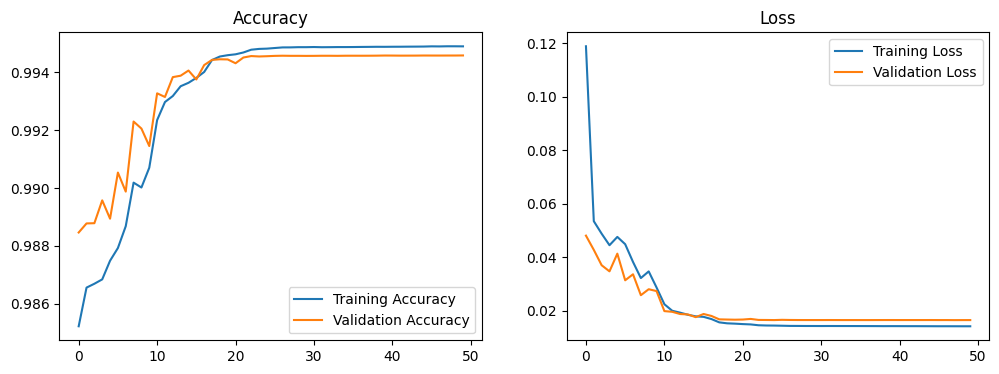

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


<Figure size 1800x5000 with 0 Axes>

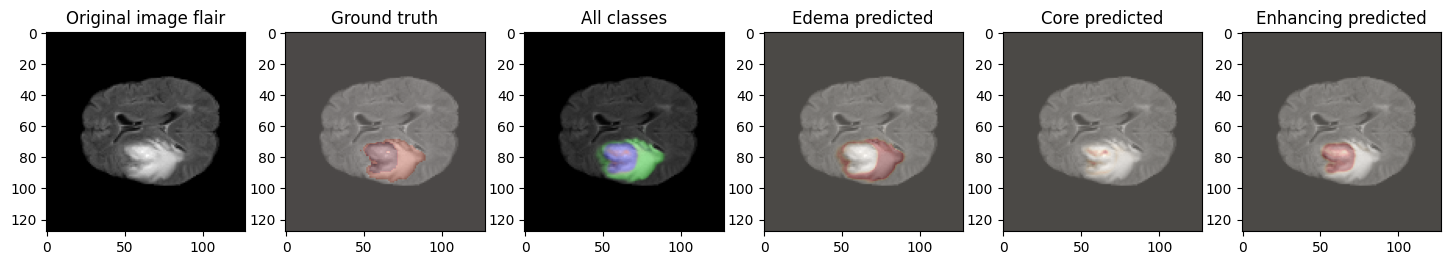

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

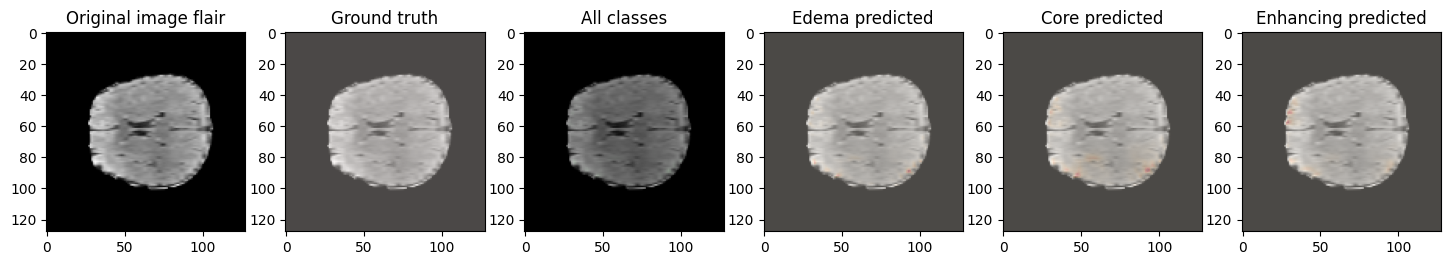

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

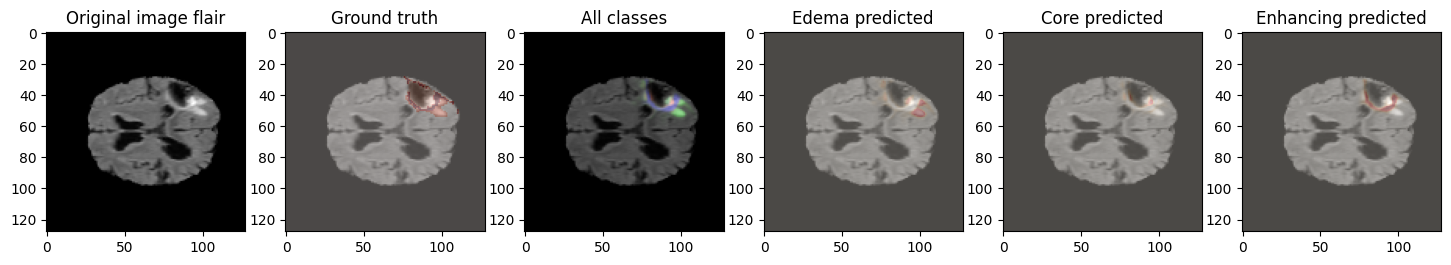

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

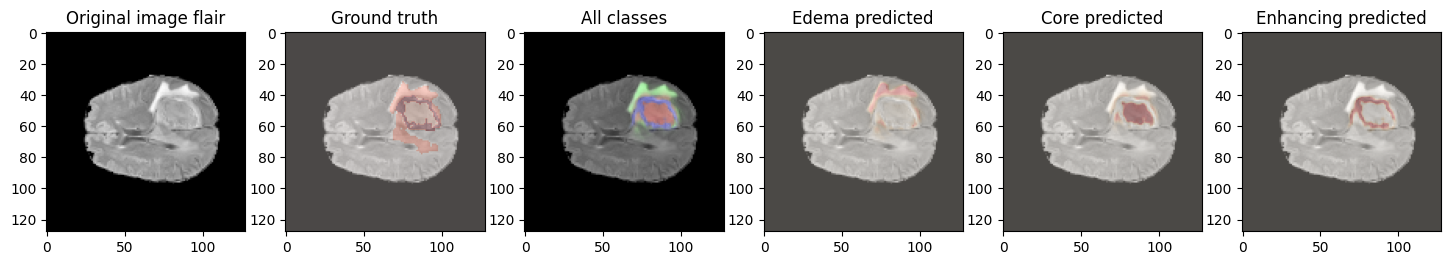

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

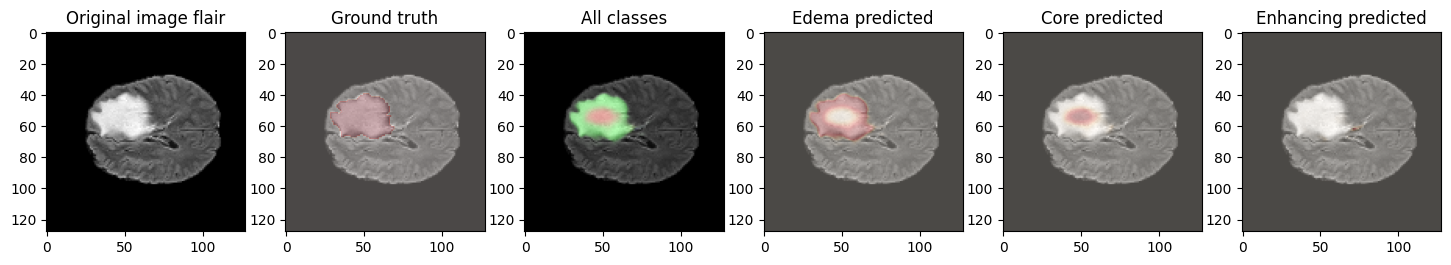

In [17]:
# Import necessary libraries
import tensorflow as tf
import os
import numpy as np
import nibabel as nib
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# U-Net Model Architecture
def build_unet(inputs, ker_init, dropout):
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Decoder
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    # Output layer
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
    return Model(inputs=inputs, outputs=outputs)

# Data Generator for Keras
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
    # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))  # One-hot encoded masks

    # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

        # Load FLAIR and T1CE modalities
            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()

        # Load segmentation mask
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
            # Resize FLAIR and T1CE slices
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

            # Resize segmentation mask slice
                mask = seg[:, :, j + VOLUME_START_AT]
                mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)  # Use nearest-neighbor interpolation

            # Convert label 4 to 3 (if necessary)
                mask[mask == 4] = 3

            # One-hot encode the mask
                mask = tf.one_hot(mask.astype(np.int32), 4)  # Shape: (IMG_SIZE, IMG_SIZE, 4)

            # Assign to y
                y[j + VOLUME_SLICES * c] = mask.numpy()  # Convert TensorFlow tensor to NumPy array

            return X / np.max(X), y

# Load dataset directories
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories.remove(TRAIN_DATASET_PATH + 'BraTS20_Training_355')

def pathListIntoIds(dirList):
    x = []
    for i in dirList:
        x.append(i[i.rfind('/') + 1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

# Create data generators
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

# Build and compile the model
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy', MeanIoU(num_classes=4)])

# Callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
    csv_logger
]

# Train the model
history = model.fit(training_generator, validation_data=valid_generator, epochs=50, callbacks=callbacks)

# Evaluate the model
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("Test loss, Test accuracy:", results)

# Visualization of training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Prediction function
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    flair = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    ce = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model.predict(X / np.max(X), verbose=1)

# Visualize predictions
def showPredictsById(case, start_slice=60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")

    axarr[0].set_title('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", alpha=0.3)
    axarr[1].set_title('Ground truth')

    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", alpha=0.3)
    axarr[2].set_title('All classes')

    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[3].set_title('Edema predicted')

    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[4].set_title('Core predicted')

    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[5].set_title('Enhancing predicted')

    plt.show()

# Show predictions for test cases
for case in test_ids[:5]:
    showPredictsById(case[-3:])

In [19]:
# Save the model in the native Keras format (recommended)
model.save('1kaz1.keras')

# Alternatively, save the model in HDF5 format (.h5)
model.save('1kaz1.h5')

# If you want to export the model as a SavedModel (for TensorFlow Lite/Serving)
model.export('saved_model_directory')

Saved artifact at 'saved_model_directory'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 2), dtype=tf.float32, name='keras_tensor_152')
Output Type:
  TensorSpec(shape=(None, 128, 128, 4), dtype=tf.float32, name=None)
Captures:
  137390569976608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390569529136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390569532480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390569526144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390569536704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390569533184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390569534240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390569533888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390569532128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390500175664: TensorSpec(shape=(), dtype=tf.resource, name=Non

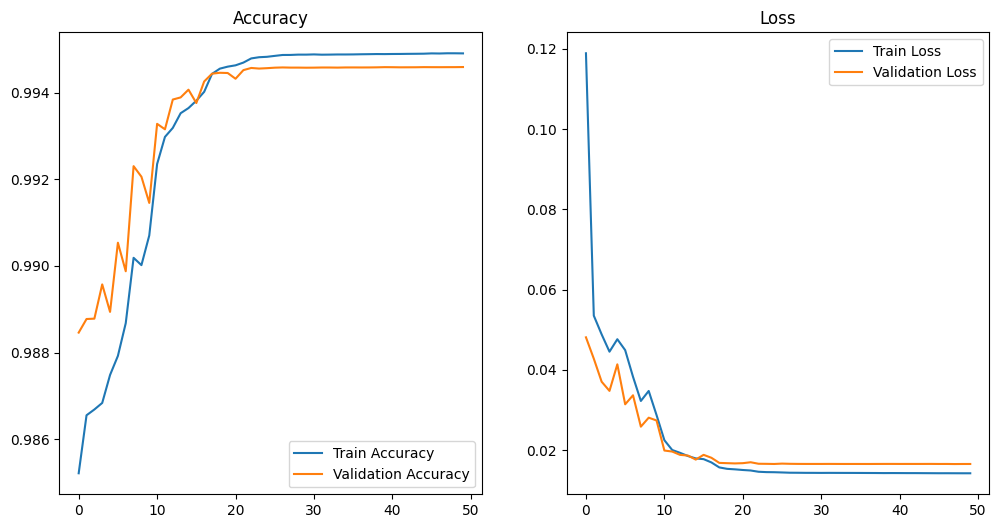

In [20]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
import gc
gc.collect()
import cv2
import os
import numpy as np
import pandas as pd
import nibabel as nib
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dropout, Conv3DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
import tensorflow as tf
import matplotlib.pyplot as plt
# Ensure GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    # Set memory growth to avoid allocating all GPU memory at once
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU is NOT available")
# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
TEST_DATASET_PATH = "../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

# Loss Functions and Metrics
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce_loss + dice_loss(y_true, y_pred)

# Build 3D U-Net Model for Segmentation
def build_unet(input_tensor):  # Accept the input tensor as an argument
    # Encoder
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_tensor)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

    # Bottleneck
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=-1)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=-1)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=-1)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=-1)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(conv9)

    return Model(inputs=input_tensor, outputs=outputs)

# Define Input Layer
input_layer = Input((IMG_SIZE, IMG_SIZE, VOLUME_SLICES, 4))

# Build and Compile Model
model = build_unet(input_layer)  # Pass the input tensor to the function
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=combined_loss,
              metrics=['accuracy', MeanIoU(num_classes=4), dice_coef])


# Data Generator Class
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE, VOLUME_SLICES), batch_size=1, n_channels=4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            t1 = nib.load(os.path.join(case_path, f'{i}_t1.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            t2 = nib.load(os.path.join(case_path, f'{i}_t2.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, :, 1] = cv2.resize(t1[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, :, 2] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, :, 3] = cv2.resize(t2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                mask = seg[:, :, j + VOLUME_START_AT]
                mask[mask == 4] = 3
                mask = tf.one_hot(mask.astype(np.int32), 4)
                Y[j + VOLUME_SLICES * c] = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE)).numpy()

        return X / np.max(X), Y

# Load Dataset
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories.remove(TRAIN_DATASET_PATH + 'BraTS20_Training_355')

def pathListIntoIds(dirList):
    return [os.path.basename(i) for i in dirList]

train_and_test_ids = pathListIntoIds(train_and_val_directories)
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

# Generators
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

# Build and Compile Model
input_layer = Input((IMG_SIZE, IMG_SIZE, VOLUME_SLICES, 4))
model = build_unet(input_layer)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=combined_loss,
              metrics=['accuracy', MeanIoU(num_classes=4), dice_coef])

# Callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)
checkpoint = ModelCheckpoint("neur_best_model.h5.keras", monitor='val_dice_coef', save_best_only=True, mode='max')

callbacks = [reduce_lr, csv_logger, checkpoint]

# Train Model
history = model.fit(training_generator,
                    validation_data=valid_generator,
                    epochs=50,
                    callbacks=callbacks)

# Save Final Model
model.save("final_brain_tumor_segmentation_model.h5")

# Plot Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(dice, label='Training Dice Coefficient')
plt.plot(val_dice, label='Validation Dice Coefficient')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history.history['mean_io_u'], label='Training Mean IoU')
plt.plot(history.history['val_mean_io_u'], label='Validation Mean IoU')
plt.legend()

plt.show()

# Testing Prediction Examples
test_data = next(iter(test_generator))
X_test, y_test = test_data
y_pred = model.predict(X_test)

for i in range(5):  # Display 5 examples
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(X_test[i, :, :, VOLUME_SLICES // 2, 0], cmap='bone')
    axes[0].set_title("Input Image")
    axes[1].imshow(np.argmax(y_test[i, :, :, VOLUME_SLICES // 2, :], axis=-1), cmap='jet')
    axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(np.argmax(y_pred[i, :, :, VOLUME_SLICES // 2, :], axis=-1), cmap='jet')
    axes[2].set_title("Predicted Mask")
    plt.show()

GPU is NOT available


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import nibabel as nib
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dropout, Conv3DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
TEST_DATASET_PATH = "../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

# Loss Functions and Metrics
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce_loss + dice_loss(y_true, y_pred)


In [3]:
def build_unet(input_tensor):  # Accept the input tensor as an argument
    # Encoder
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_tensor)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

    # Bottleneck
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=-1)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    
    up7 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=-1)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=-1)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=-1)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(conv9)

    return Model(inputs=input_tensor, outputs=outputs)

In [1]:
pip install tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Define Input Layer
input_layer = Input((IMG_SIZE, IMG_SIZE, VOLUME_SLICES, 4))

# Build and Compile Model
model = build_unet(input_layer)  # Pass the input tensor to the function
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=combined_loss,
              metrics=['accuracy', MeanIoU(num_classes=4), dice_coef])

In [6]:
# Data Generator Class
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE, VOLUME_SLICES), batch_size=1, n_channels=4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            t1 = nib.load(os.path.join(case_path, f'{i}_t1.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            t2 = nib.load(os.path.join(case_path, f'{i}_t2.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, :, 1] = cv2.resize(t1[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, :, 2] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, :, 3] = cv2.resize(t2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                mask = seg[:, :, j + VOLUME_START_AT]
                mask[mask == 4] = 3
                mask = tf.one_hot(mask.astype(np.int32), 4)
                Y[j + VOLUME_SLICES * c] = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE)).numpy()

        return X / np.max(X), Y

In [7]:
# Load Dataset
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories.remove(TRAIN_DATASET_PATH + 'BraTS20_Training_355')

def pathListIntoIds(dirList):
    return [os.path.basename(i) for i in dirList]

train_and_test_ids = pathListIntoIds(train_and_val_directories)
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

# Generators
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


In [8]:
# Build and Compile Model
input_layer = Input((IMG_SIZE, IMG_SIZE, VOLUME_SLICES, 4))
model = build_unet(input_layer)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=combined_loss,
              metrics=['accuracy', MeanIoU(num_classes=4), dice_coef])

# Callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)
checkpoint = ModelCheckpoint("neur_best_model.h5.keras", monitor='val_dice_coef', save_best_only=True, mode='max')

callbacks = [reduce_lr, csv_logger, checkpoint]

In [ ]:
# Train Model
history = model.fit(training_generator,
                    validation_data=valid_generator,
                    epochs=50,
                    callbacks=callbacks)

# Save Final Model
model.save("final_brain_tumor_segmentation_model.h5")

# Plot Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(dice, label='Training Dice Coefficient')
plt.plot(val_dice, label='Validation Dice Coefficient')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history.history['mean_io_u'], label='Training Mean IoU')
plt.plot(history.history['val_mean_io_u'], label='Validation Mean IoU')
plt.legend()

plt.show()

In [1]:
!nvidia-smi

Sat Feb 15 19:58:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Import necessary libraries
import tensorflow as tf
import os
import numpy as np
import nibabel as nib
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Dice Coefficient Function
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_wt(y_true, y_pred):
    y_true_wt = tf.reduce_sum(y_true[..., 1:], axis=-1)
    y_pred_wt = tf.reduce_sum(y_pred[..., 1:], axis=-1)
    y_pred_wt = tf.cast(y_pred_wt > 0.5, 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_coef_tc(y_true, y_pred):
    y_true_tc = y_true[...,1] + y_true[...,3]
    y_pred_tc = y_pred[...,1] + y_pred[...,3]
    y_pred_tc = tf.cast(y_pred_tc > 0.5, 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_coef_et(y_true, y_pred):
    y_true_et = y_true[...,3]
    y_pred_et = y_pred[...,3]
    y_pred_et = tf.cast(y_pred_et > 0.5, 'float32')
    return dice_coef(y_true_et, y_pred_et)

# U-Net Model Architecture
def build_unet(inputs, ker_init, dropout):
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Decoder
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    # Output layer
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
    return Model(inputs=inputs, outputs=outputs)

# Data Generator for Keras
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4), dtype=np.float32)  # Initialize with float32

        for c, case_id in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, case_id)

            flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
            ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                mask = seg[:, :, j + VOLUME_START_AT]
                mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                mask[mask == 4] = 3  # Convert label 4 to 3

                mask_encoded = tf.one_hot(mask.astype(np.int32), 4)
                y[j + VOLUME_SLICES * c] = mask_encoded.numpy()

        X_normalized = X / np.max(X)
        return X_normalized, y

# Load dataset directories
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
excluded_case = 'BraTS20_Training_355'
train_and_val_directories = [d for d in train_and_val_directories if excluded_case not in d]

def pathListIntoIds(dirList):
    return [os.path.basename(i) for i in dirList]

train_and_test_ids = pathListIntoIds(train_and_val_directories)
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# Create data generators
training_generator = DataGenerator(train_ids, batch_size=1)
valid_generator = DataGenerator(val_ids, batch_size=1)
test_generator = DataGenerator(test_ids, batch_size=1)

# Build and compile the model
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        MeanIoU(num_classes=4),
        dice_coef_wt,
        dice_coef_tc,
        dice_coef_et
    ]
)

# Callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)
checkpoint = ModelCheckpoint(
    'neurobest_model.h5.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

callbacks = [reduce_lr, csv_logger, checkpoint]

# Train the model
history = model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=callbacks
)

# Save the final model
model.save('brain_tumor_segmentation_model.h5')

# Evaluate the model
results = model.evaluate(test_generator, batch_size=1, callbacks=callbacks)
print("Test loss, Test accuracy:", results)

# Visualize training history
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 3)
dice_metrics = ['dice_coef_wt', 'val_dice_coef_wt', 'dice_coef_tc', 'val_dice_coef_tc', 'dice_coef_et', 'val_dice_coef_et']
for metric in dice_metrics:
    plt.plot(history.history[metric], label=metric)
plt.legend()
plt.title('Dice Coefficients')
plt.show()

# Prediction and visualization functions
def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    flair = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    ce = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')).get_fdata()
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    return model.predict(X / np.max(X), verbose=1)

def showPredictsById(case, start_slice=60):
    path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case}')
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")

    axarr[0].set_title('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", alpha=0.3)
    axarr[1].set_title('Ground truth')

    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", alpha=0.3)
    axarr[2].set_title('All classes')

    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[3].set_title('Edema predicted')

    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[4].set_title('Core predicted')

    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[5].set_title('Enhancing predicted')

    plt.show()

# Show predictions for test cases
for case in test_ids[:5]:
    showPredictsById(case[-3:])

Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9604 - dice_coef_et: 0.0548 - dice_coef_tc: 2.8629e-10 - dice_coef_wt: 0.0092 - loss: 0.2564 - mean_io_u_1: 0.4759
Epoch 1: val_loss improved from inf to 0.05325, saving model to neurobest_model.h5.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 198s 740ms/step - accuracy: 0.9604 - dice_coef_et: 0.0548 - dice_coef_tc: 2.8618e-10 - dice_coef_wt: 0.0092 - loss: 0.2558 - mean_io_u_1: 0.4759 - val_accuracy: 0.9876 - val_dice_coef_et: 0.0811 - val_dice_coef_tc: 3.3963e-10 - val_dice_coef_wt: 0.0445 - val_loss: 0.0532 - val_mean_io_u_1: 0.5000 - learning_rate: 0.0010
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.9865 - dice_coef_et: 0.0441 - dice_coef_tc: 3.0426e-10 - dice_coef_wt: 0.0573 - loss: 0.0570 - mean_io_u_1: 0.5059
Epoch 2: val_loss did not improve from 0.05325
249/249 ━━━━━━━━━━━━━━━━━━━━ 183s 724ms/step - accuracy: 0.9865 - dice_coef_et: 0.0442 - dice_coef_tc: 3.0409e-10 - dice_coef_wt: 0.0574 - loss: 0.

In [6]:
print(os.listdir(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355')))

['BraTS20_Training_355_flair.nii', 'W39_1998.09.19_Segm.nii', 'BraTS20_Training_355_t2.nii', 'BraTS20_Training_355_t1.nii', 'BraTS20_Training_355_t1ce.nii']


Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9542 - dice_coef_et: 0.0755 - dice_coef_tc: 6.4081e-05 - dice_coef_wt: 0.0095 - loss: 0.2053 - mean_io_u_5: 0.4718
Epoch 1: val_loss improved from inf to 0.07125, saving model to neurobest_model.h5.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 237s 894ms/step - accuracy: 0.9543 - dice_coef_et: 0.0755 - dice_coef_tc: 6.3868e-05 - dice_coef_wt: 0.0095 - loss: 0.2048 - mean_io_u_5: 0.4719 - val_accuracy: 0.9876 - val_dice_coef_et: 0.0811 - val_dice_coef_tc: 3.3963e-10 - val_dice_coef_wt: 0.1420 - val_loss: 0.0712 - val_mean_io_u_5: 0.5000 - learning_rate: 0.0010
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9865 - dice_coef_et: 0.0603 - dice_coef_tc: 2.8094e-10 - dice_coef_wt: 0.0437 - loss: 0.0645 - mean_io_u_5: 0.5075
Epoch 2: val_loss improved from 0.07125 to 0.05130, saving model to neurobest_model.h5.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 180s 714ms/step - accuracy: 0.9865 - dice_coef_et: 0.0603 - dice_coef_tc

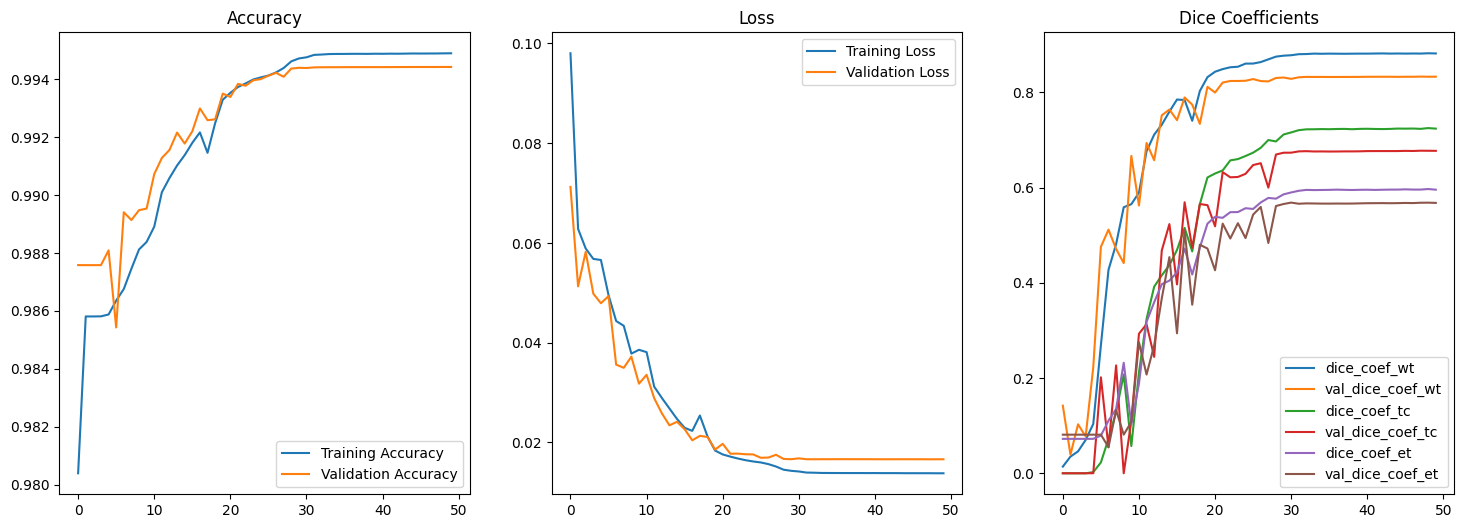

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


<Figure size 1800x5000 with 0 Axes>

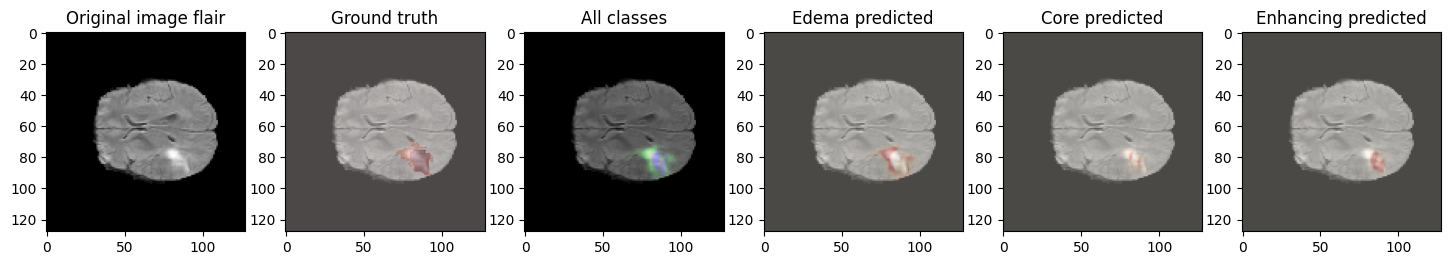

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

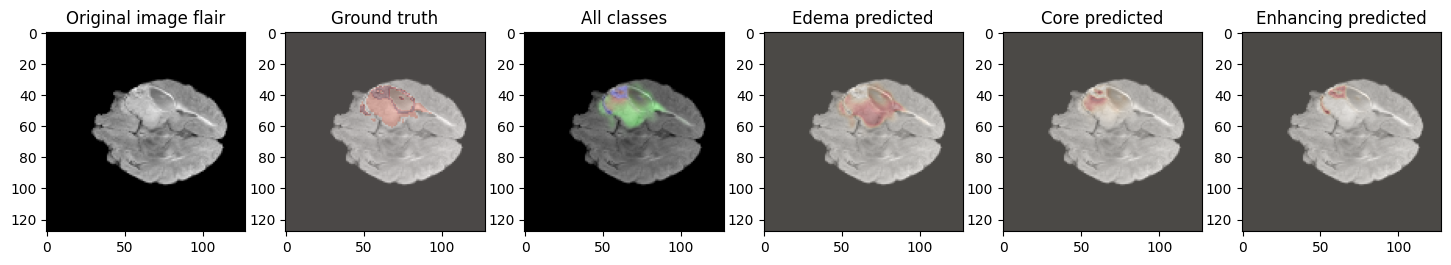

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

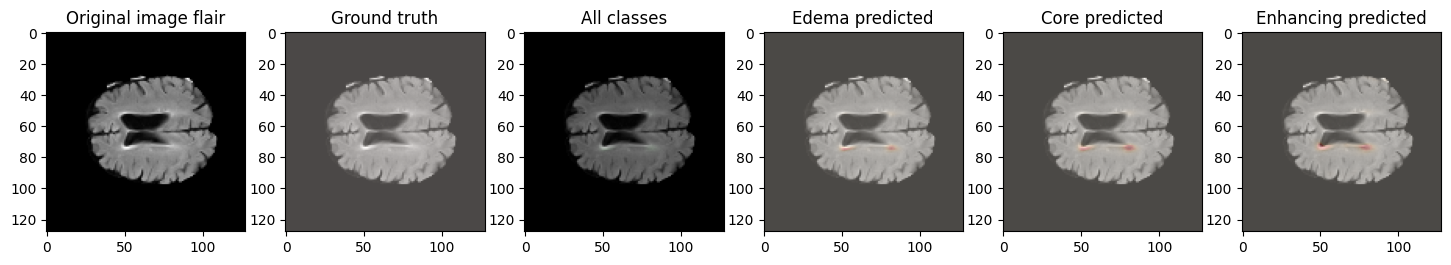

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

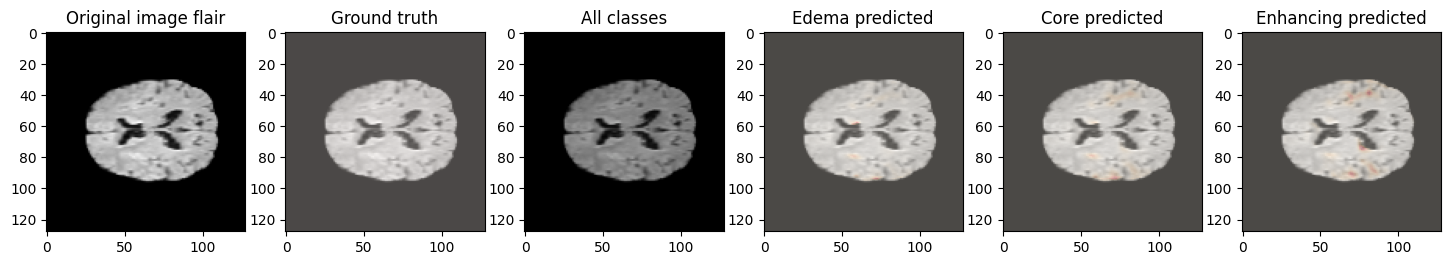

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

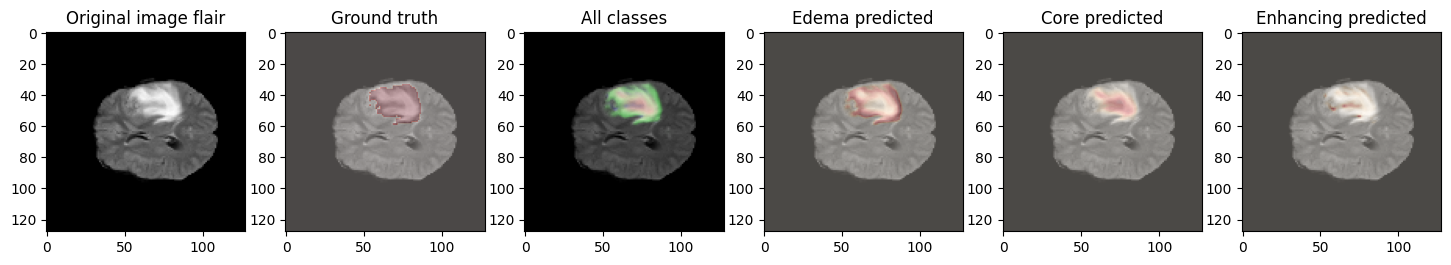

In [11]:
# Import necessary libraries
import tensorflow as tf
import os
import numpy as np
import nibabel as nib
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Dice Coefficient Function
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_wt(y_true, y_pred):
    y_true_wt = tf.reduce_sum(y_true[..., 1:], axis=-1)
    y_pred_wt = tf.reduce_sum(y_pred[..., 1:], axis=-1)
    y_pred_wt = tf.cast(y_pred_wt > 0.5, 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_coef_tc(y_true, y_pred):
    y_true_tc = y_true[...,1] + y_true[...,3]
    y_pred_tc = y_pred[...,1] + y_pred[...,3]
    y_pred_tc = tf.cast(y_pred_tc > 0.5, 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_coef_et(y_true, y_pred):
    y_true_et = y_true[...,3]
    y_pred_et = y_pred[...,3]
    y_pred_et = tf.cast(y_pred_et > 0.5, 'float32')
    return dice_coef(y_true_et, y_pred_et)

# U-Net Model Architecture
def build_unet(inputs, ker_init, dropout):
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Decoder
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    # Output layer
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
    return Model(inputs=inputs, outputs=outputs)

# Data Generator for Keras
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4), dtype=np.float32)  # Initialize with float32

        for c, case_id in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, case_id)

            flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
            ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                mask = seg[:, :, j + VOLUME_START_AT]
                mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                mask[mask == 4] = 3  # Convert label 4 to 3

                mask_encoded = tf.one_hot(mask.astype(np.int32), 4)
                y[j + VOLUME_SLICES * c] = mask_encoded.numpy()

        X_normalized = X / np.max(X)
        return X_normalized, y

# Load dataset directories
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
excluded_case = 'BraTS20_Training_355'
train_and_val_directories = [d for d in train_and_val_directories if excluded_case not in d]

def pathListIntoIds(dirList):
    return [os.path.basename(i) for i in dirList]

train_and_test_ids = pathListIntoIds(train_and_val_directories)
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# Create data generators
training_generator = DataGenerator(train_ids, batch_size=1)
valid_generator = DataGenerator(val_ids, batch_size=1)
test_generator = DataGenerator(test_ids, batch_size=1)

# Build and compile the model
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        MeanIoU(num_classes=4),
        dice_coef_wt,
        dice_coef_tc,
        dice_coef_et
    ]
)

# Callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)
checkpoint = ModelCheckpoint(
    'neurobest_model.h5.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

callbacks = [reduce_lr, csv_logger, checkpoint]

# Train the model
history = model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=callbacks
)

# Save the final model
model.save('brain_tumor_segmentation_model.h5')

# Evaluate the model
results = model.evaluate(test_generator, batch_size=1, callbacks=callbacks)
print("Test loss, Test accuracy:", results)

# Visualize training history
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 3)
dice_metrics = ['dice_coef_wt', 'val_dice_coef_wt', 'dice_coef_tc', 'val_dice_coef_tc', 'dice_coef_et', 'val_dice_coef_et']
for metric in dice_metrics:
    plt.plot(history.history[metric], label=metric)
plt.legend()
plt.title('Dice Coefficients')
plt.show()

# Prediction and visualization functions
def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    flair = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    ce = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')).get_fdata()
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    return model.predict(X / np.max(X), verbose=1)

def showPredictsById(case, start_slice=60):
    path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case}')
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")

    axarr[0].set_title('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", alpha=0.3)
    axarr[1].set_title('Ground truth')

    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", alpha=0.3)
    axarr[2].set_title('All classes')

    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[3].set_title('Edema predicted')

    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[4].set_title('Core predicted')

    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[5].set_title('Enhancing predicted')

    plt.show()

# Show predictions for test cases
for case in test_ids[:5]:
    showPredictsById(case[-3:])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5825 - dice_coef_et: 0.0594 - dice_coef_tc: 0.0287 - dice_coef_wt: 0.0273 - loss: 6.8910 - mean_io_u: 0.2522
Epoch 1: val_mean_io_u improved from -inf to 0.25000, saving model to jan_neurobest_model.h5.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.5833 - dice_coef_et: 0.0597 - dice_coef_tc: 0.0289 - dice_coef_wt: 0.0273 - loss: 6.8878 - mean_io_u: 0.2522 - val_accuracy: 0.9760 - val_dice_coef_et: 0.1002 - val_dice_coef_tc: 0.1038 - val_dice_coef_wt: 0.0081 - val_loss: 5.3747 - val_mean_io_u: 0.2500 - learning_rate: 1.0000e-04
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.9741 - dice_coef_et: 0.3579 - dice_coef_tc: 0.2337 - dice_coef_wt: 0.0459 - loss: 4.6713 - mean_io_u: 0.2522
Epoch 2: val_mean_io_u did not improve from 0.25000
249/249 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9742 - dice_coef_et: 0.3580 - dice_coef_tc: 0.2340 - dice_coef_wt: 0.0461 - loss: 4.6700 - mean_io_u: 0.2522 - va

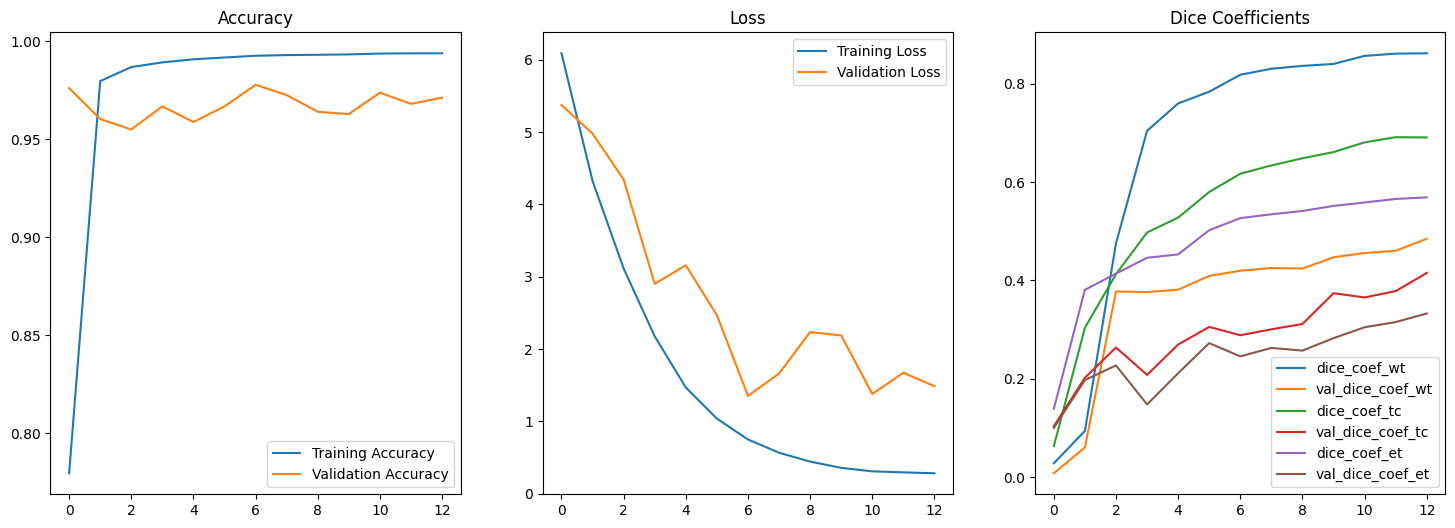

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


<Figure size 1800x5000 with 0 Axes>

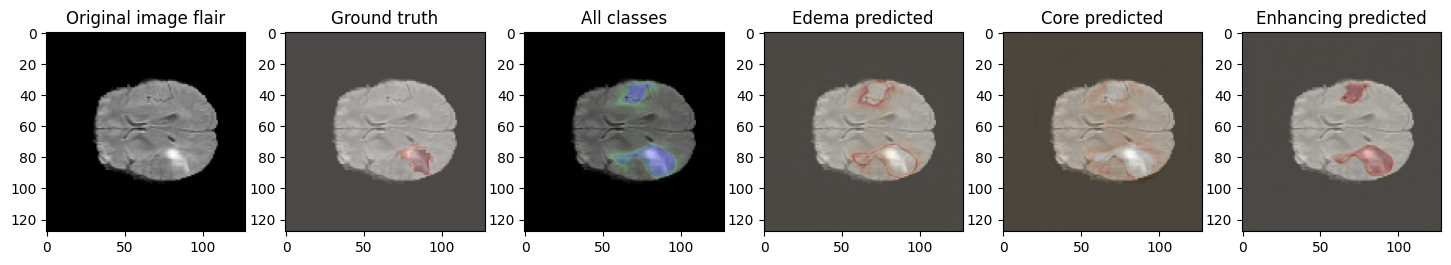

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

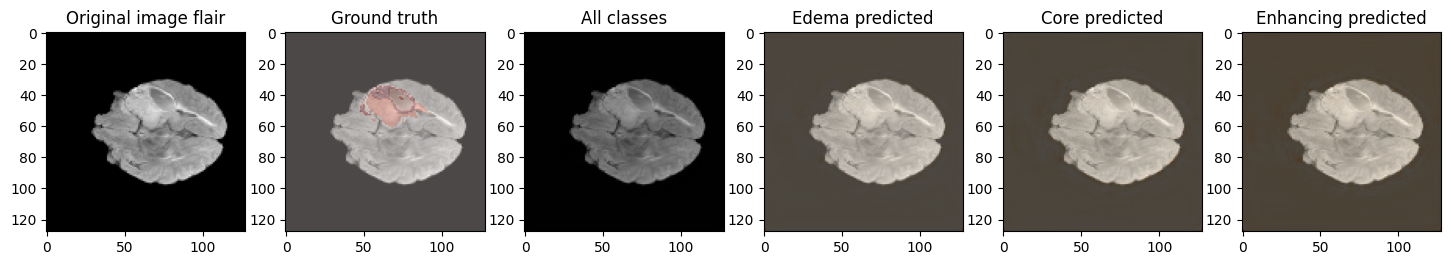

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

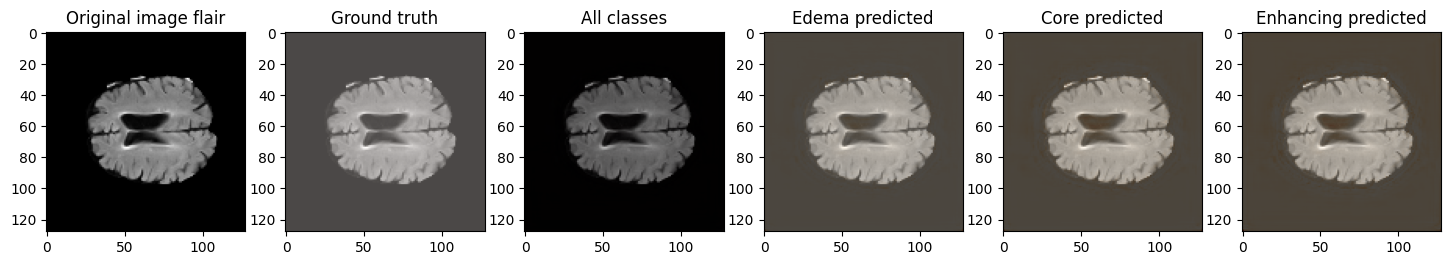

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

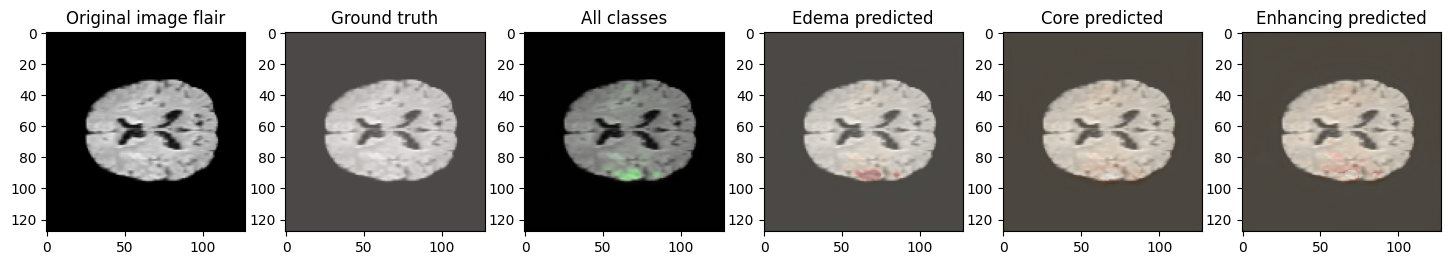

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

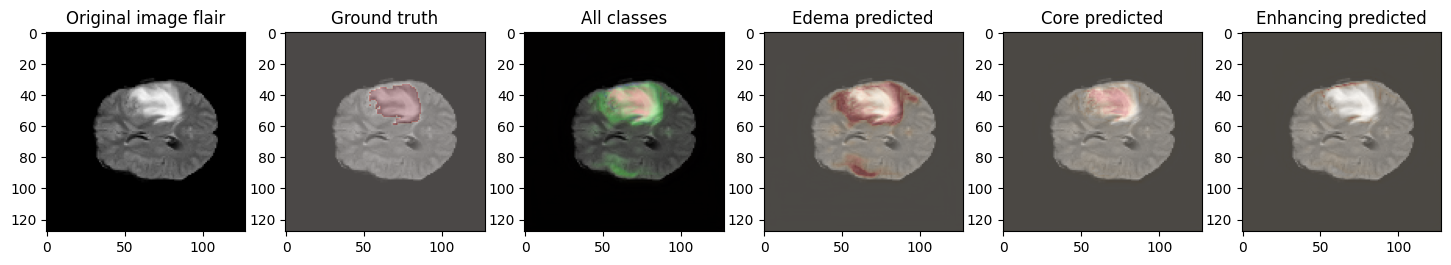

In [5]:
import os
# Import necessary libraries
import tensorflow as tf
import numpy as np
import nibabel as nib
import cv2
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Dice Coefficient Function
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_wt(y_true, y_pred):
    y_true_wt = tf.reduce_sum(y_true[..., 1:], axis=-1)
    y_pred_wt = tf.reduce_sum(y_pred[..., 1:], axis=-1)
    y_pred_wt = tf.cast(y_pred_wt > 0.5, 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_coef_tc(y_true, y_pred):
    y_true_tc = y_true[..., 1] + y_true[..., 3]
    y_pred_tc = y_pred[..., 1] + y_pred[..., 3]
    y_pred_tc = tf.cast(y_pred_tc > 0.5, 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_coef_et(y_true, y_pred):
    y_true_et = y_true[..., 3]
    y_pred_et = y_pred[..., 3]
    y_pred_et = tf.cast(y_pred_et > 0.5, 'float32')
    return dice_coef(y_true_et, y_pred_et)

# Weighted Dice Loss
def weighted_dice_loss(weights):
    weights = K.constant(weights)  # Convert weights to a TensorFlow constant
    
    def loss(y_true, y_pred):
        smooth = 1e-6
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice_loss = 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
        # Reshape weights to [4, 1, 1, 1] to match the class dimension
        weights_reshaped = K.reshape(weights, (-1, 1, 1, 1))
        
        # Compute cross-entropy loss with weighted classes
        ce_loss = K.categorical_crossentropy(y_true, y_pred)
        weighted_ce = K.mean(ce_loss * weights_reshaped)
        
        return dice_loss + weighted_ce
    
    return loss

# U-Net Model Architecture with Batch Normalization
def build_unet(inputs, ker_init, dropout):
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Decoder
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(drop5))
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv6))
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv7))
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv8))
    up9 = BatchNormalization()(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)
    conv9 = BatchNormalization()(conv9)

    # Output layer
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
    return Model(inputs=inputs, outputs=outputs)

# Data Generator with Dynamic File Detection and Augmentation
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augmentation = True  # Enable augmentations
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4), dtype=np.float32)

        for c, case_id in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, case_id)

            # Dynamically detect FLAIR, T1CE, and segmentation files
            flair_path = None
            t1ce_path = None
            seg_path = None

            for fn in os.listdir(case_path):
                if 'flair' in fn.lower() and fn.endswith('.nii'):
                    flair_path = os.path.join(case_path, fn)
                if 't1ce' in fn.lower() and fn.endswith('.nii'):
                    t1ce_path = os.path.join(case_path, fn)
                if 'seg' in fn.lower() and fn.endswith('.nii'):
                    seg_path = os.path.join(case_path, fn)

            # Ensure all files are found
            if not (flair_path and t1ce_path and seg_path):
                error_msg = f"Files missing for case: {case_id}\n"
                if not flair_path: error_msg += " - FLAIR not found\n"
                if not t1ce_path: error_msg += " - T1CE not found\n"
                if not seg_path: error_msg += " - Segmentation not found\n"
                raise FileNotFoundError(error_msg)

            # Load data
            flair = nib.load(flair_path).get_fdata()
            ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            # Process each slice
            for j in range(VOLUME_SLICES):
                X_slice_flair = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X_slice_ce = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                mask = seg[:, :, j + VOLUME_START_AT]
                mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                mask[mask == 4] = 3  # Convert label 4 to 3

                # Apply augmentations
                if self.augmentation:
                    # Random rotation
                    angle = np.random.uniform(-15, 15)
                    X_slice_flair = rotate(X_slice_flair, angle, reshape=False, order=1)
                    X_slice_ce = rotate(X_slice_ce, angle, reshape=False, order=1)
                    mask = rotate(mask, angle, reshape=False, order=0)

                    # Random horizontal flip
                    if np.random.rand() < 0.5:
                        X_slice_flair = np.fliplr(X_slice_flair)
                        X_slice_ce = np.fliplr(X_slice_ce)
                        mask = np.fliplr(mask)

                # Assign to X and y
                X[j + VOLUME_SLICES * c, :, :, 0] = X_slice_flair
                X[j + VOLUME_SLICES * c, :, :, 1] = X_slice_ce

                mask_encoded = tf.one_hot(mask.astype(np.int32), 4)
                y[j + VOLUME_SLICES * c] = mask_encoded.numpy()

        X_normalized = X / np.max(X)
        return X_normalized, y

# Load dataset directories
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
excluded_case = 'BraTS20_Training_355'
train_and_val_directories = [d for d in train_and_val_directories if excluded_case not in d]

def pathListIntoIds(dirList):
    return [os.path.basename(i) for i in dirList]

train_and_test_ids = pathListIntoIds(train_and_val_directories)
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# Create data generators
training_generator = DataGenerator(train_ids, batch_size=1, shuffle=True)
valid_generator = DataGenerator(val_ids, batch_size=1, shuffle=False)  # Keep validation data unshuffled
test_generator = DataGenerator(test_ids, batch_size=1, shuffle=False)

# Define class weights (adjust based on dataset analysis)
class_weights = np.array([1.0, 5.0, 2.0, 10.0])  # Example weights
weighted_loss = weighted_dice_loss(class_weights)

# Build and compile the model
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(
    loss=weighted_loss,
    optimizer=Adam(learning_rate=1e-4),  # Adjusted learning rate
    metrics=[
        'accuracy',
        MeanIoU(num_classes=4, name='mean_io_u'),
        dice_coef_wt,
        dice_coef_tc,
        dice_coef_et
    ]
)

# Callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(
    'jan_neurobest_model.h5.keras',
    monitor='val_mean_io_u',  # Monitor validation Mean IoU
    verbose=1,
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

callbacks = [reduce_lr, csv_logger, checkpoint, early_stopping]

# Train the model
history = model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=callbacks
)

# Save the final model
model.save('jan_brain_tumor_segmentation_model.h5')

# Evaluate the model
results = model.evaluate(test_generator, batch_size=1)
print("Test loss, Test accuracy:", results)

# Visualize training history
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 3)
dice_metrics = ['dice_coef_wt', 'val_dice_coef_wt', 'dice_coef_tc', 'val_dice_coef_tc', 'dice_coef_et', 'val_dice_coef_et']
for metric in dice_metrics:
    plt.plot(history.history[metric], label=metric)
plt.legend()
plt.title('Dice Coefficients')
plt.show()

# Prediction and visualization functions
def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    flair = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    ce = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')).get_fdata()
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    return model.predict(X / np.max(X), verbose=1)

def showPredictsById(case, start_slice=60):
    path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case}')
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")

    axarr[0].set_title('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", alpha=0.3)
    axarr[1].set_title('Ground truth')

    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", alpha=0.3)
    axarr[2].set_title('All classes')

    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[3].set_title('Edema predicted')

    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[4].set_title('Core predicted')

    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", alpha=0.3)
    axarr[5].set_title('Enhancing predicted')

    plt.show()

# Show predictions for test cases
for case in test_ids[:5]:
    showPredictsById(case[-3:])

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


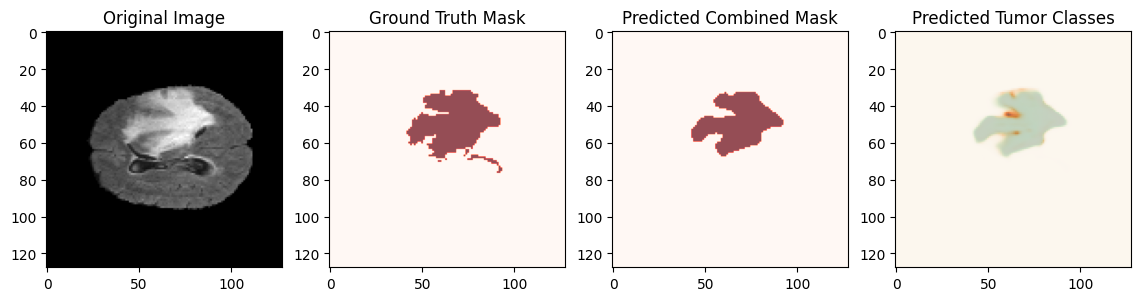

In [5]:
# Import necessary libraries
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Dice Coefficient Function (required for model loading)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_wt(y_true, y_pred):
    y_true_wt = tf.reduce_sum(y_true[..., 1:], axis=-1)
    y_pred_wt = tf.reduce_sum(y_pred[..., 1:], axis=-1)
    y_pred_wt = tf.cast(y_pred_wt > 0.5, 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_coef_tc(y_true, y_pred):
    y_true_tc = y_true[...,1] + y_true[...,3]
    y_pred_tc = y_pred[...,1] + y_pred[...,3]
    y_pred_tc = tf.cast(y_pred_tc > 0.5, 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_coef_et(y_true, y_pred):
    y_true_et = y_true[...,3]
    y_pred_et = y_pred[...,3]
    y_pred_et = tf.cast(y_pred_et > 0.5, 'float32')
    return dice_coef(y_true_et, y_pred_et)

# Function to predict a case using the saved model
def predict_case(case_id):
    # Load the saved model
    model = load_model(
        '/kaggle/input/brain/keras/default/1/brain_tumor_segmentation_model.h5',
        custom_objects={
            'dice_coef': dice_coef,
            'dice_coef_wt': dice_coef_wt,
            'dice_coef_tc': dice_coef_tc,
            'dice_coef_et': dice_coef_et,
            'MeanIoU': tf.keras.metrics.MeanIoU
        }
    )

    case_path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case_id}')

    # Dynamically detect files
    flair_path = None
    t1ce_path = None
    seg_path = None

    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
        if 't1ce' in fn.lower() and fn.endswith('.nii'):
            t1ce_path = os.path.join(case_path, fn)
        if 'seg' in fn.lower() and fn.endswith('.nii'):
            seg_path = os.path.join(case_path, fn)

    if not (flair_path and t1ce_path and seg_path):
        raise FileNotFoundError("Missing files for case: BraTS20_Training_{}".format(case_id))

    # Load and preprocess data
    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(t1ce_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    X_normalized = X / np.max(X)

    # Make prediction
    predictions = model.predict(X_normalized, batch_size=1, verbose=1)

    return predictions, seg

# Function to visualize predictions
def visualize_predictions(case_id, start_slice=60):
    predictions, seg = predict_case(case_id)

    case_folder = f'BraTS20_Training_{case_id}'
    case_path = os.path.join(TRAIN_DATASET_PATH, case_folder)

    # Load ground truth segmentation
    seg_mask = seg[:, :, start_slice + VOLUME_START_AT]
    seg_mask = cv2.resize(seg_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Load original FLAIR image
    flair_path = None
    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
            break
    origImage = nib.load(flair_path).get_fdata()

    # Get predicted mask slice
    pred_mask = predictions[start_slice]

    # Display results
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(seg_mask, cmap="Reds", alpha=0.7)
    plt.title('Ground Truth Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(np.argmax(pred_mask, axis=-1), cmap="Reds", alpha=0.7)
    plt.title('Predicted Combined Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(pred_mask[:, :, 1], cmap="Blues", alpha=0.7)  # Whole tumor
    plt.imshow(pred_mask[:, :, 2], cmap="Greens", alpha=0.7)  # Core tumor
    plt.imshow(pred_mask[:, :, 3], cmap="Oranges", alpha=0.7)  # Enhancing tumor
    plt.title('Predicted Tumor Classes')

    plt.show()

# Example usage: load and visualize a case
case_id = '001'  # Replace with your case ID (e.g., '001', '002', etc.)
visualize_predictions(case_id)

128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step


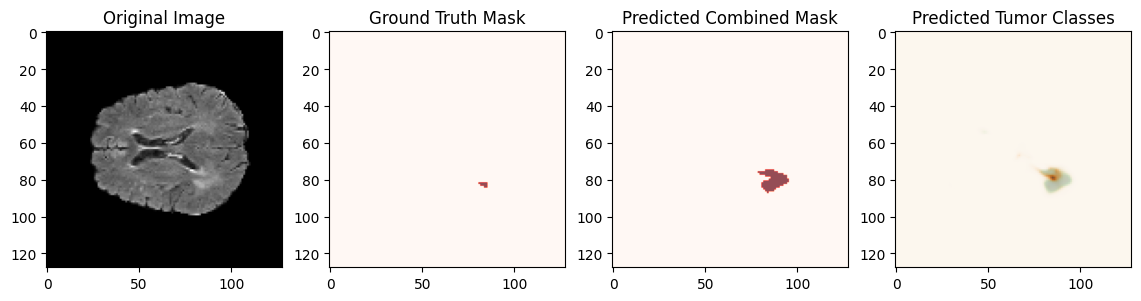

In [3]:
# Import necessary libraries
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Dice Coefficient Function (required for model loading)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_wt(y_true, y_pred):
    y_true_wt = tf.reduce_sum(y_true[..., 1:], axis=-1)
    y_pred_wt = tf.reduce_sum(y_pred[..., 1:], axis=-1)
    y_pred_wt = tf.cast(y_pred_wt > 0.5, 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_coef_tc(y_true, y_pred):
    y_true_tc = y_true[...,1] + y_true[...,3]
    y_pred_tc = y_pred[...,1] + y_pred[...,3]
    y_pred_tc = tf.cast(y_pred_tc > 0.5, 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_coef_et(y_true, y_pred):
    y_true_et = y_true[...,3]
    y_pred_et = y_pred[...,3]
    y_pred_et = tf.cast(y_pred_et > 0.5, 'float32')
    return dice_coef(y_true_et, y_pred_et)

# Function to predict a case using the saved model
def predict_case(case_id):
    # Load the saved model
    model = load_model(
        '/kaggle/input/brain/keras/default/1/brain_tumor_segmentation_model.h5',
        custom_objects={
            'dice_coef': dice_coef,
            'dice_coef_wt': dice_coef_wt,
            'dice_coef_tc': dice_coef_tc,
            'dice_coef_et': dice_coef_et,
            'MeanIoU': tf.keras.metrics.MeanIoU
        }
    )

    case_path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case_id}')

    # Dynamically detect files
    flair_path = None
    t1ce_path = None
    seg_path = None

    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
        if 't1ce' in fn.lower() and fn.endswith('.nii'):
            t1ce_path = os.path.join(case_path, fn)
        if 'seg' in fn.lower() and fn.endswith('.nii'):
            seg_path = os.path.join(case_path, fn)

    if not (flair_path and t1ce_path and seg_path):
        raise FileNotFoundError("Missing files for case: BraTS20_Training_{}".format(case_id))

    # Load and preprocess data
    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(t1ce_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    X_normalized = X / np.max(X)

    # Make prediction
    predictions = model.predict(X_normalized, batch_size=1, verbose=1)

    return predictions, seg

# Function to visualize predictions
def visualize_predictions(case_id, start_slice=60):
    predictions, seg = predict_case(case_id)

    case_folder = f'BraTS20_Training_{case_id}'
    case_path = os.path.join(TRAIN_DATASET_PATH, case_folder)

    # Load ground truth segmentation
    seg_mask = seg[:, :, start_slice + VOLUME_START_AT]
    seg_mask = cv2.resize(seg_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Load original FLAIR image
    flair_path = None
    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
            break
    origImage = nib.load(flair_path).get_fdata()

    # Get predicted mask slice
    pred_mask = predictions[start_slice]

    # Display results
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(seg_mask, cmap="Reds", alpha=0.7)
    plt.title('Ground Truth Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(np.argmax(pred_mask, axis=-1), cmap="Reds", alpha=0.7)
    plt.title('Predicted Combined Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(pred_mask[:, :, 1], cmap="Blues", alpha=0.7)  # Whole tumor
    plt.imshow(pred_mask[:, :, 2], cmap="Greens", alpha=0.7)  # Core tumor
    plt.imshow(pred_mask[:, :, 3], cmap="Oranges", alpha=0.7)  # Enhancing tumor
    plt.title('Predicted Tumor Classes')

    plt.show()

# Example usage: load and visualize a case
case_id = '007'  # Replace with your case ID (e.g., '001', '002', etc.)
visualize_predictions(case_id)

128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step


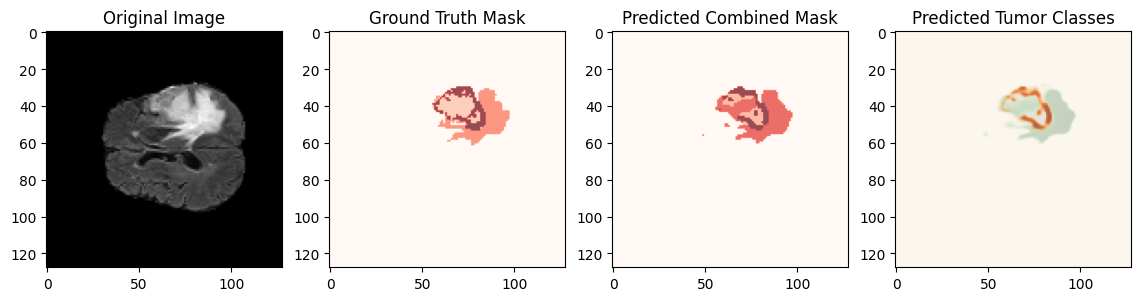

In [7]:
# Import necessary libraries
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Dice Coefficient Function (required for model loading)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_wt(y_true, y_pred):
    y_true_wt = tf.reduce_sum(y_true[..., 1:], axis=-1)
    y_pred_wt = tf.reduce_sum(y_pred[..., 1:], axis=-1)
    y_pred_wt = tf.cast(y_pred_wt > 0.5, 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_coef_tc(y_true, y_pred):
    y_true_tc = y_true[...,1] + y_true[...,3]
    y_pred_tc = y_pred[...,1] + y_pred[...,3]
    y_pred_tc = tf.cast(y_pred_tc > 0.5, 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_coef_et(y_true, y_pred):
    y_true_et = y_true[...,3]
    y_pred_et = y_pred[...,3]
    y_pred_et = tf.cast(y_pred_et > 0.5, 'float32')
    return dice_coef(y_true_et, y_pred_et)

# Function to predict a case using the saved model
def predict_case(case_id):
    # Load the saved model
    model = load_model(
        '/kaggle/input/brain/keras/default/1/brain_tumor_segmentation_model.h5',
        custom_objects={
            'dice_coef': dice_coef,
            'dice_coef_wt': dice_coef_wt,
            'dice_coef_tc': dice_coef_tc,
            'dice_coef_et': dice_coef_et,
            'MeanIoU': tf.keras.metrics.MeanIoU
        }
    )

    case_path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case_id}')

    # Dynamically detect files
    flair_path = None
    t1ce_path = None
    seg_path = None

    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
        if 't1ce' in fn.lower() and fn.endswith('.nii'):
            t1ce_path = os.path.join(case_path, fn)
        if 'seg' in fn.lower() and fn.endswith('.nii'):
            seg_path = os.path.join(case_path, fn)

    if not (flair_path and t1ce_path and seg_path):
        raise FileNotFoundError("Missing files for case: BraTS20_Training_{}".format(case_id))

    # Load and preprocess data
    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(t1ce_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    X_normalized = X / np.max(X)

    # Make prediction
    predictions = model.predict(X_normalized, batch_size=1, verbose=1)

    return predictions, seg

# Function to visualize predictions
def visualize_predictions(case_id, start_slice=60):
    predictions, seg = predict_case(case_id)

    case_folder = f'BraTS20_Training_{case_id}'
    case_path = os.path.join(TRAIN_DATASET_PATH, case_folder)

    # Load ground truth segmentation
    seg_mask = seg[:, :, start_slice + VOLUME_START_AT]
    seg_mask = cv2.resize(seg_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Load original FLAIR image
    flair_path = None
    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
            break
    origImage = nib.load(flair_path).get_fdata()

    # Get predicted mask slice
    pred_mask = predictions[start_slice]

    # Display results
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(seg_mask, cmap="Reds", alpha=0.7)
    plt.title('Ground Truth Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(np.argmax(pred_mask, axis=-1), cmap="Reds", alpha=0.7)
    plt.title('Predicted Combined Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(pred_mask[:, :, 1], cmap="Blues", alpha=0.7)  # Whole tumor
    plt.imshow(pred_mask[:, :, 2], cmap="Greens", alpha=0.7)  # Core tumor
    plt.imshow(pred_mask[:, :, 3], cmap="Oranges", alpha=0.7)  # Enhancing tumor
    plt.title('Predicted Tumor Classes')

    plt.show()

# Example usage: load and visualize a case
case_id = '100'  # Replace with your case ID (e.g., '001', '002', etc.)
visualize_predictions(case_id)

128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step


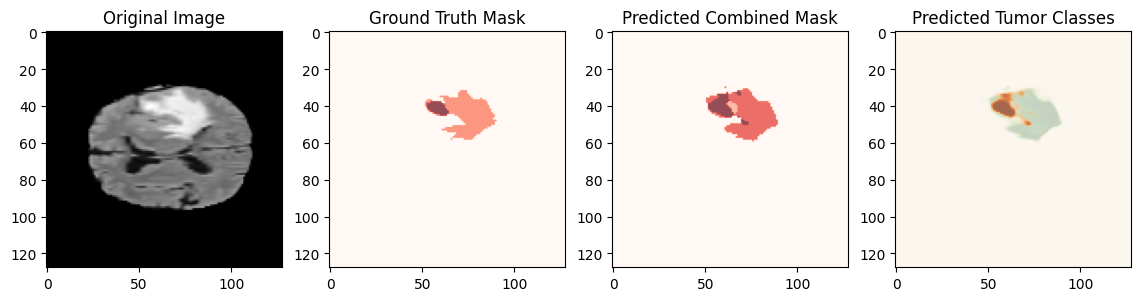

In [10]:
# Import necessary libraries
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Dice Coefficient Function (required for model loading)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_wt(y_true, y_pred):
    y_true_wt = tf.reduce_sum(y_true[..., 1:], axis=-1)
    y_pred_wt = tf.reduce_sum(y_pred[..., 1:], axis=-1)
    y_pred_wt = tf.cast(y_pred_wt > 0.5, 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_coef_tc(y_true, y_pred):
    y_true_tc = y_true[...,1] + y_true[...,3]
    y_pred_tc = y_pred[...,1] + y_pred[...,3]
    y_pred_tc = tf.cast(y_pred_tc > 0.5, 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_coef_et(y_true, y_pred):
    y_true_et = y_true[...,3]
    y_pred_et = y_pred[...,3]
    y_pred_et = tf.cast(y_pred_et > 0.5, 'float32')
    return dice_coef(y_true_et, y_pred_et)

# Function to predict a case using the saved model
def predict_case(case_id):
    # Load the saved model
    model = load_model(
        '/kaggle/input/brain/keras/default/1/brain_tumor_segmentation_model.h5',
        custom_objects={
            'dice_coef': dice_coef,
            'dice_coef_wt': dice_coef_wt,
            'dice_coef_tc': dice_coef_tc,
            'dice_coef_et': dice_coef_et,
            'MeanIoU': tf.keras.metrics.MeanIoU
        }
    )

    case_path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case_id}')

    # Dynamically detect files
    flair_path = None
    t1ce_path = None
    seg_path = None

    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
        if 't1ce' in fn.lower() and fn.endswith('.nii'):
            t1ce_path = os.path.join(case_path, fn)
        if 'seg' in fn.lower() and fn.endswith('.nii'):
            seg_path = os.path.join(case_path, fn)

    if not (flair_path and t1ce_path and seg_path):
        raise FileNotFoundError("Missing files for case: BraTS20_Training_{}".format(case_id))

    # Load and preprocess data
    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(t1ce_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    X_normalized = X / np.max(X)

    # Make prediction
    predictions = model.predict(X_normalized, batch_size=1, verbose=1)

    return predictions, seg

# Function to visualize predictions
def visualize_predictions(case_id, start_slice=60):
    predictions, seg = predict_case(case_id)

    case_folder = f'BraTS20_Training_{case_id}'
    case_path = os.path.join(TRAIN_DATASET_PATH, case_folder)

    # Load ground truth segmentation
    seg_mask = seg[:, :, start_slice + VOLUME_START_AT]
    seg_mask = cv2.resize(seg_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Load original FLAIR image
    flair_path = None
    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
            break
    origImage = nib.load(flair_path).get_fdata()

    # Get predicted mask slice
    pred_mask = predictions[start_slice]

    # Display results
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(seg_mask, cmap="Reds", alpha=0.7)
    plt.title('Ground Truth Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(np.argmax(pred_mask, axis=-1), cmap="Reds", alpha=0.7)
    plt.title('Predicted Combined Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(pred_mask[:, :, 1], cmap="Blues", alpha=0.7)  # Whole tumor
    plt.imshow(pred_mask[:, :, 2], cmap="Greens", alpha=0.7)  # Core tumor
    plt.imshow(pred_mask[:, :, 3], cmap="Oranges", alpha=0.7)  # Enhancing tumor
    plt.title('Predicted Tumor Classes')

    plt.show()

# Example usage: load and visualize a case
case_id = '130'  # Replace with your case ID (e.g., '001', '002', etc.)
visualize_predictions(case_id)

128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step


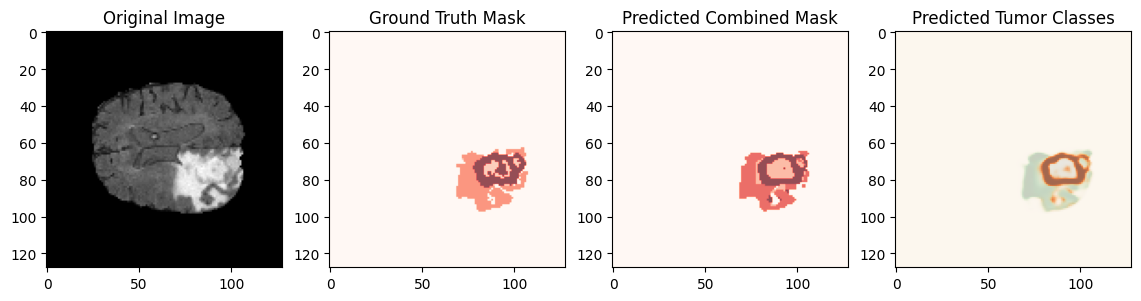

In [3]:
# Import necessary libraries
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 128
VOLUME_START_AT = 25
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Dice Coefficient Function (required for model loading)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_wt(y_true, y_pred):
    y_true_wt = tf.reduce_sum(y_true[..., 1:], axis=-1)
    y_pred_wt = tf.reduce_sum(y_pred[..., 1:], axis=-1)
    y_pred_wt = tf.cast(y_pred_wt > 0.5, 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_coef_tc(y_true, y_pred):
    y_true_tc = y_true[...,1] + y_true[...,3]
    y_pred_tc = y_pred[...,1] + y_pred[...,3]
    y_pred_tc = tf.cast(y_pred_tc > 0.5, 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_coef_et(y_true, y_pred):
    y_true_et = y_true[...,3]
    y_pred_et = y_pred[...,3]
    y_pred_et = tf.cast(y_pred_et > 0.5, 'float32')
    return dice_coef(y_true_et, y_pred_et)

# Function to predict a case using the saved model
def predict_case(case_id):
    # Load the saved model
    model = load_model(
        '/kaggle/input/brain/keras/default/1/brain_tumor_segmentation_model.h5',
        custom_objects={
            'dice_coef': dice_coef,
            'dice_coef_wt': dice_coef_wt,
            'dice_coef_tc': dice_coef_tc,
            'dice_coef_et': dice_coef_et,
            'MeanIoU': tf.keras.metrics.MeanIoU
        }
    )

    case_path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case_id}')

    # Dynamically detect files
    flair_path = None
    t1ce_path = None
    seg_path = None

    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
        if 't1ce' in fn.lower() and fn.endswith('.nii'):
            t1ce_path = os.path.join(case_path, fn)
        if 'seg' in fn.lower() and fn.endswith('.nii'):
            seg_path = os.path.join(case_path, fn)

    if not (flair_path and t1ce_path and seg_path):
        raise FileNotFoundError("Missing files for case: BraTS20_Training_{}".format(case_id))

    # Load and preprocess data
    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(t1ce_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    X_normalized = X / np.max(X)

    # Make prediction
    predictions = model.predict(X_normalized, batch_size=1, verbose=1)

    return predictions, seg

# Function to visualize predictions
def visualize_predictions(case_id, start_slice=60):
    predictions, seg = predict_case(case_id)

    case_folder = f'BraTS20_Training_{case_id}'
    case_path = os.path.join(TRAIN_DATASET_PATH, case_folder)

    # Load ground truth segmentation
    seg_mask = seg[:, :, start_slice + VOLUME_START_AT]
    seg_mask = cv2.resize(seg_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Load original FLAIR image
    flair_path = None
    for fn in os.listdir(case_path):
        if 'flair' in fn.lower() and fn.endswith('.nii'):
            flair_path = os.path.join(case_path, fn)
            break
    origImage = nib.load(flair_path).get_fdata()

    # Get predicted mask slice
    pred_mask = predictions[start_slice]

    # Display results
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(seg_mask, cmap="Reds", alpha=0.7)
    plt.title('Ground Truth Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(np.argmax(pred_mask, axis=-1), cmap="Reds", alpha=0.7)
    plt.title('Predicted Combined Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(pred_mask[:, :, 1], cmap="Blues", alpha=0.7)  # Whole tumor
    plt.imshow(pred_mask[:, :, 2], cmap="Greens", alpha=0.7)  # Core tumor
    plt.imshow(pred_mask[:, :, 3], cmap="Oranges", alpha=0.7)  # Enhancing tumor
    plt.title('Predicted Tumor Classes')

    plt.show()

# Example usage: load and visualize a case
case_id = '201'  # Replace with  ID (e.g., '001', '002', etc.)
visualize_predictions(case_id)

In [ ]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores